----
## <div><font color='green'> Machine Learning | Assignment 2, Task 1</font></div>
## <div> <font color='Red'> s3656436 : Rhys Reid Mallia </font></div>
----

This notebook was created for COSC2673, Machine Learning Assignment 2. 

The goal of this assignment is to use a modified version of the `CRCHistoPhenotypes` dataset to build 2 categorical classifiers for 27x27 images of colon cells from 99 different patients.

The first model will be used to predict the outcome of the `isCancerous` class, using the `cancer_data` dataset.

The second model will be used to predict the outcome of the multi-variable class `cell-type`, using the `cell_data` dataset.

This Notebook contains the following sections:

*  Data Preparation
*  Data Exploration
*  Model Construction
*  Model Evaluation

# Data Preparation
## Neural network and other classifiers dataframes

In [840]:
#Extracting the datasets
import zipfile
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
%matplotlib inline




In [841]:
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_extract:
    zip_extract.extractall('./')

In [842]:
#Creating the two dataframes
cancer_data = pd.read_csv('./data_labels_mainData.csv')
cell_data = cancer_data

#Creating an extra dataframe for the extra data
extra_data = pd.read_csv('./data_labels_extraData.csv')

In [843]:
#Sanity check to ensure the data is correctly loaded
cancer_data.sample(5)

InstanceID  patientID ImageName  cellTypeName  cellType  isCancerous
7570         758         48   758.png        others         3            0
968         4704          8  4704.png  inflammatory         1            0
2305        3013         14  3013.png    fibroblast         0            0
3464        1150         19  1150.png        others         3            0
2169        4534         13  4534.png    epithelial         2            1

In [844]:
#checking that each category is correctly formatted
print("Shape of mainData:", cancer_data.shape)
print(cancer_data.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Shape of extraData:", extra_data.shape)
print(extra_data.info())

Shape of mainData: (9896, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of extraData: (10384, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 32

In [845]:
#The categories "InstanceID" and "PatientID" in all dataframes serves no
#purpose to the outcome of the task. 
cancer_data = cancer_data.drop(['InstanceID'], axis = 1)
cancer_data = cancer_data.drop(['patientID'], axis = 1)

cell_data = cell_data.drop(['InstanceID'], axis = 1)
cell_data = cell_data.drop(['patientID'], axis = 1)

extra_data = extra_data.drop(['InstanceID'], axis = 1)
extra_data = extra_data.drop(['patientID'], axis = 1)

#the feature cellTypeName is also an unnessicary identifier
cancer_data = cancer_data.drop(['cellTypeName'], axis = 1)
cell_data = cell_data.drop(['cellTypeName'], axis = 1)

#The feature cellType in cancer_data does not have a purpose in the task, 
#or may cause bias as only value 2 is related to a cancerous identification
cancer_data = cancer_data.drop(['cellType'], axis = 1)

print("cancer_data: Dtypes\n", cancer_data.dtypes,"\n\n",
      "cell_data: Dtypes\n", cell_data.dtypes, "\n\n", "extra_data: dtypes\n",
     extra_data.dtypes)

cancer_data: Dtypes
 ImageName      object
isCancerous     int64
dtype: object 

 cell_data: Dtypes
 ImageName      object
cellType        int64
isCancerous     int64
dtype: object 

 extra_data: dtypes
 ImageName      object
isCancerous     int64
dtype: object


In [846]:
#isCancerous and celltype are being identified as an integer column, this should
#be converted into a categorical feature.
cancer_data['isCancerous'] = cancer_data['isCancerous'].astype('category')

cell_data['isCancerous'] = cell_data['isCancerous'].astype('category')
cell_data['cellType'] = cell_data['cellType'].astype('category')

extra_data['isCancerous'] = extra_data['isCancerous'].astype('category')
print("cancer_data: Dtypes\n", cancer_data.dtypes,"\n\n",
      "cell_data: Dtypes\n", cell_data.dtypes, "\n\n", "extra_data: dtypes\n",
     extra_data.dtypes)

cancer_data: Dtypes
 ImageName        object
isCancerous    category
dtype: object 

 cell_data: Dtypes
 ImageName        object
cellType       category
isCancerous    category
dtype: object 

 extra_data: dtypes
 ImageName        object
isCancerous    category
dtype: object


In [847]:
#Check for any missing values in any of the datasets
print(cancer_data.isnull().sum(), "\n\n", cell_data.isnull().sum(), "\n\n", 
     extra_data.isnull().sum())

ImageName      0
isCancerous    0
dtype: int64 

 ImageName      0
cellType       0
isCancerous    0
dtype: int64 

 ImageName      0
isCancerous    0
dtype: int64


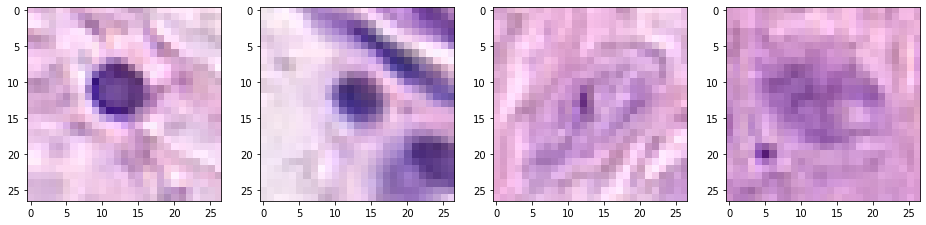

In [848]:
#Selecting an image from cancer and cell type dataframe
from PIL import Image
r_inx = np.random.choice(100, 4)
rand = cancer_data.loc[r_inx, 'ImageName']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand):
    img = np.asarray(Image.open("./patch_images/" + image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(img)    
    

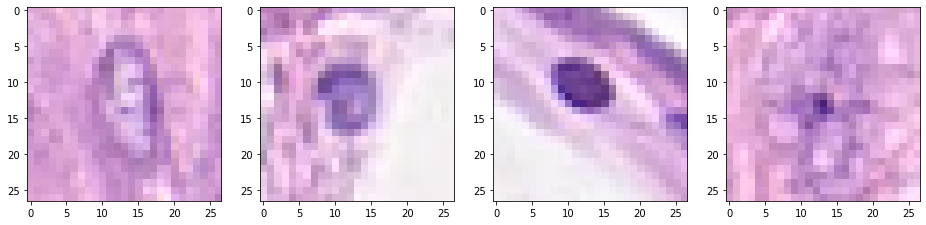

In [849]:
r_inx = np.random.choice(100, 4)
rand = cell_data.loc[r_inx, 'ImageName']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand):
    img = np.asarray(Image.open("./patch_images/" + image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(img)   

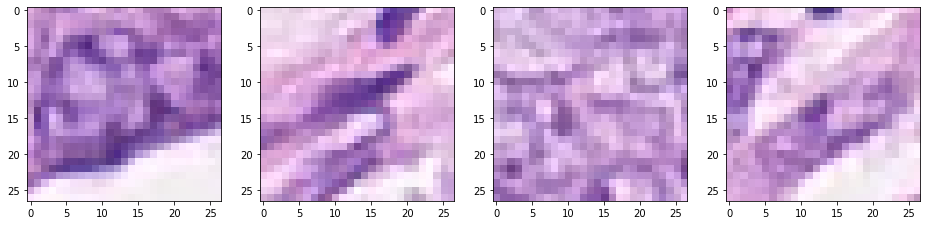

In [850]:
r_inx = np.random.choice(100, 4)
rand = extra_data.loc[r_inx, 'ImageName']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand):
    img = np.asarray(Image.open("./patch_images/" + image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(img)   

In [851]:
#Hold out validation - creating the train, test and validation splits
from sklearn.model_selection import train_test_split

cc_train_data, cc_test_data = train_test_split(cancer_data, test_size=0.2, random_state=42)
cc_train_data, cc_val_data = train_test_split(cc_train_data, test_size=0.25, random_state=42)

cl_train_data, cl_test_data = train_test_split(cell_data, test_size=0.2, random_state=42)
cl_train_data, cl_val_data = train_test_split(cl_train_data, test_size=0.25, random_state=42)

ex_train_data, ex_test_data = train_test_split(extra_data, test_size=0.2, random_state=42)
ex_train_data, ex_val_data = train_test_split(ex_train_data, test_size=0.25, random_state=42)

print("Cancer_data = Train data: {}, Val Data: {}, Test Data: {}".format(cc_train_data.shape[0], cc_val_data.shape[0], cc_test_data.shape[0]))
print("Cell_data = Train data : {}, Val Data: {}, Test Data: {}".format(cl_train_data.shape[0], cl_val_data.shape[0], cl_test_data.shape[0]))
print("Extra_data = Train data : {}, Val Data: {}, Test Data: {}".format(ex_train_data.shape[0], ex_val_data.shape[0], ex_test_data.shape[0]))

Cancer_data = Train data: 5937, Val Data: 1979, Test Data: 1980
Cell_data = Train data : 5937, Val Data: 1979, Test Data: 1980
Extra_data = Train data : 6230, Val Data: 2077, Test Data: 2077


In [852]:
print(cc_train_data.head)

<bound method NDFrame.head of       ImageName isCancerous
9533  22266.png           0
310   18717.png           0
9480  21202.png           0
7073  18114.png           0
8977  14070.png           1
...         ...         ...
7872   5524.png           1
5624  11996.png           1
401     224.png           0
3394   1071.png           0
9349  16857.png           0

[5937 rows x 2 columns]>


In [853]:
#Creating a new train test split for the other models, as they benefit from a larger set of training data
cc_alt_train_data, cc_alt_test_data = train_test_split(cancer_data, test_size=0.2, random_state=42)
cl_alt_train_data, cl_alt_test_data = train_test_split(cell_data, test_size=0.2, random_state=42)

print("Cancer_data = Train data: {}, Test Data: {}".format(cc_alt_train_data.shape[0], cc_alt_test_data.shape[0]))
print("Cell_data = Train data : {}, Test Data: {}".format(cl_alt_train_data.shape[0], cl_alt_test_data.shape[0]))

Cancer_data = Train data: 7916, Test Data: 1980
Cell_data = Train data : 7916, Test Data: 1980


In [854]:
#creating a pandas dataframe of the images to use in exploration and other models
import cv2

cancer_train_X = []
cancer_test_X = []
#cancer_val_X = []

cell_train_X = []
cell_test_X = []
#cell_val_X = []

extra_train_X = []
extra_test_X = []
#extra_val_X = []


data_frames = [cc_alt_train_data, cc_alt_test_data, cl_alt_train_data, cl_alt_test_data]
data_structures = [cancer_train_X, cancer_test_X, cell_train_X, cell_test_X]

for x in range(4):
    print(x)
    for i in data_frames[x].ImageName:
        #print("./patch_images/" + i)
        #r = Image.open("./patch_images/" + i)
        r = cv2.imread("./patch_images/" + i)
        #converting the image to greyscale to simplify later on
        r = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        data_structures[x].append(np.array(r))
        
        
        #print(r)
        #print(np.array(r).shape)
        #img_check = Image.fromarray(r)
        #plt.imshow(img_check)
        #img_check.show()
        
        #np.append(data_structures[x], np.array(r), axis=0)
        #np.concatenate((data_structures[x][count], np.array(r)))
        #print(np.array(r))
        #np.vstack((data_structures[x], np.array(r)))
        
        
        #print(data_structures[x])
        #imgs.append(np.array(r))
        #r.close()
        #count = count + 1
        

0
1
2
3


In [855]:
##Converting data to numpy array
cancer_train_X = np.array(cancer_train_X)
print(cancer_train_X.shape)

cancer_test_X = np.array(cancer_test_X)
print(cancer_test_X.shape)

#cancer_val_X = np.array(cancer_val_X)
#print(cancer_val_X.shape)

cell_train_X = np.array(cell_train_X)
print(cell_train_X.shape)
cell_test_X = np.array(cell_test_X)
print(cell_test_X.shape)
#cell_val_X = np.array(cell_val_X)

#extra_train_X = np.array(extra_train_X)
#extra_test_X = np.array(extra_test_X)
#extra_val_X = np.array(extra_val_X)
#print(cancer_train_X)
#print(cancer_train_X)

(7916, 27, 27)
(1980, 27, 27)
(7916, 27, 27)
(1980, 27, 27)


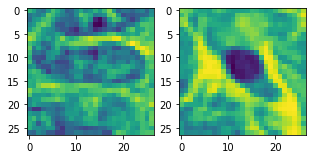

In [856]:
#printing the first image in the dataset to ensure everything is working
plt.figure(figsize=[5,5])
size = (27, 27)

plt.subplot(121)
curr_img = np.reshape(cancer_train_X[0], size)
plt.imshow(curr_img)

plt.subplot(122)
curr_img = np.reshape(cell_test_X[0], size)
plt.imshow(curr_img)



In [857]:
#Creating and flattening the Y to be used on non-NN models
cancer_train_y = cc_alt_train_data[['isCancerous']]
cancer_test_y = cc_alt_test_data[['isCancerous']]
#cancer_val_y = cc_val_data[['isCancerous']]

cell_train_y = cl_alt_train_data[['cellType']]
cell_test_y = cl_alt_test_data[['cellType']]
#cell_val_y = cl_val_data[['cellType']]

#extra_train_y = ex_train_data[['isCancerous']]
#extra_test_y = ex_test_data[['isCancerous']]
#extra_val_y = ex_val_data[['isCancerous']]

In [858]:
#converting y to numpy array
cancer_train_y_list = cancer_train_y
cancer_train_y = np.array(cancer_train_y)
cancer_test_y = np.array(cancer_test_y)
#cancer_val_y= np.array(cancer_val_y)

cell_train_y = np.array(cell_train_y)
cell_test_y = np.array(cell_test_y)
#cell_val_y = np.array(cell_val_y)

c_n_classes = np.unique(cancer_train_y)
c_classes = len(c_n_classes)
cl_n_classes = np.unique(cell_train_y)
cl_classes = len(cl_n_classes)

print(cell_train_y.shape)
print('total number of Cancer_Data outputs: ', c_n_classes)
print('Cancer_data output classes: ', c_classes)
print(cell_train_y.shape)
print('total number of cell_data outputs: ', cl_n_classes)
print('Cell_data output classes: ', cl_classes)

(7916, 1)
total number of Cancer_Data outputs:  [0 1]
Cancer_data output classes:  2
(7916, 1)
total number of cell_data outputs:  [0 1 2 3]
Cell_data output classes:  4


In [859]:
#converting the image location labels to be string for the data generator
cc_train_data['ImageName'] = cc_train_data['ImageName'].astype('str')
cc_train_data['isCancerous'] = cc_train_data['isCancerous'].astype('str')

cc_test_data['ImageName'] = cc_test_data['ImageName'].astype('str')
cc_test_data['isCancerous'] = cc_test_data['isCancerous'].astype('str')

cc_val_data['ImageName']= cc_val_data['ImageName'].astype('str')
cc_val_data['isCancerous']= cc_val_data['isCancerous'].astype('str')


cl_train_data['ImageName'] = cl_train_data['ImageName'].astype('str')
cl_train_data['cellType'] = cl_train_data['cellType'].astype('str')

cl_test_data['ImageName'] = cl_test_data['ImageName'].astype('str')
cl_test_data['cellType'] = cl_test_data['cellType'].astype('str')

cl_val_data['ImageName'] = cl_val_data['ImageName'].astype('str')
cl_val_data['cellType'] = cl_val_data['cellType'].astype('str')


ex_train_data['ImageName'] = ex_train_data['ImageName'].astype('str')
ex_train_data['isCancerous'] = ex_train_data['isCancerous'].astype('str')

ex_test_data['ImageName'] = ex_test_data['ImageName'].astype('str')
ex_test_data['isCancerous'] = ex_test_data['isCancerous'].astype('str')

ex_val_data['ImageName'] = ex_val_data['ImageName'].astype('str')
ex_val_data['isCancerous'] = ex_val_data['isCancerous'].astype('str')

In [860]:
#creating the image data generators for the cancer images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

cc_train_generator = train_datagen.flow_from_dataframe(
        dataframe=cc_train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cc_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=cc_val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cc_X_train, cc_y_train = next(cc_train_generator)
cc_X_val, cc_y_train = next(cc_validation_generator)

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [861]:
cc_test_generator = train_datagen.flow_from_dataframe(
        dataframe=cc_test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


In [862]:
cl_train_generator = train_datagen.flow_from_dataframe(
        dataframe=cl_train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cl_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=cl_val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cl_X_train, cl_y_train = next(cl_train_generator)
cl_X_val, cl_y_train = next(cl_validation_generator)

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [863]:
cl_test_generator = val_datagen.flow_from_dataframe(
        dataframe=cl_test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


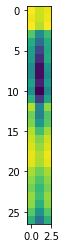

In [864]:
#Display the first component of the image to see how the generator splits
#the images, and to make sure they are applicatable to the NN model
r_inx = np.random.choice(100, 4)

plt.subplot(121)
curr_img = cl_X_train[0][26]
plt.imshow(curr_img)

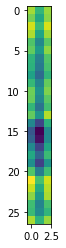

In [865]:
plt.subplot(121)
curr_img = cl_X_val[0][0]
plt.imshow(curr_img)

# Data exploration

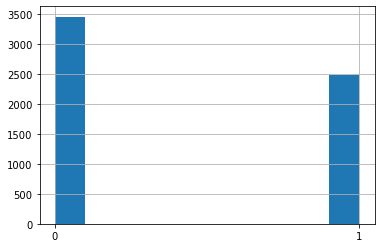

In [866]:
#check if the distribution of the data is even between the classes
cc_train_data.isCancerous.hist()
plt.show()

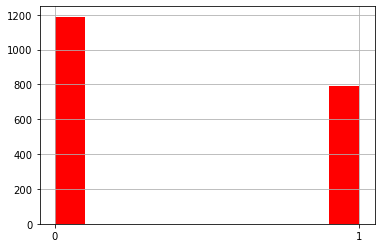

In [867]:
cc_test_data.isCancerous.hist(color='r')
plt.show()

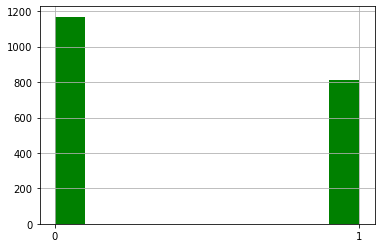

In [868]:
cc_val_data.isCancerous.hist(color='g')
plt.show()

While the distribution of isCancerous[0], and isCancerous[1] is similar in each instance of the training, testing and validation data, overall there is a bias towards non-cancerous images. This may result in a bias model and affect the performance and accuracy.

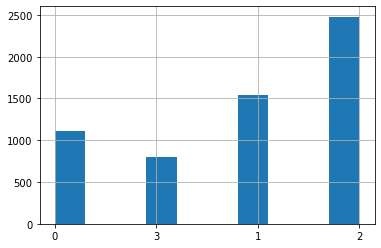

In [869]:
cl_train_data.cellType.hist()
plt.show()

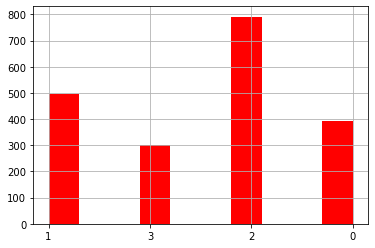

In [870]:
cl_test_data.cellType.hist(color='r')
plt.show()

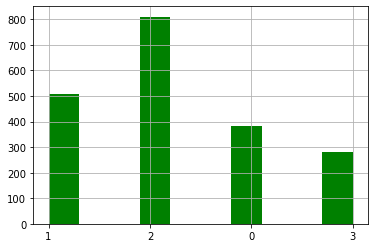

In [871]:
cl_val_data.cellType.hist(color='g')
plt.show()

With the cellType classification, there is a bias towards cellType[2], which is the cancerous cellType. 

There is also not many instances of cellType[3], which may cause errors when predicting this in the validation dataset.


In [872]:
#calculate the mean of the datasets
print("Mean of the cancer training set: ", np.mean(cancer_train_X))
print("Mean of the cancer testing set: ", np.mean(cancer_test_X))
#print("Mean of the cancer validation set: ", np.mean(cancer_val_X))

print("\n", "Mean of the cell training set: ", np.mean(cell_train_X))
print("Mean of the cell testing set: ", np.mean(cell_test_X))
#print("Mean of the cell validation set: ", np.mean(cell_val_X))


Mean of the cancer training set:  169.26414232153664
Mean of the cancer testing set:  169.98101314932592

 Mean of the cell training set:  169.26414232153664
Mean of the cell testing set:  169.98101314932592


The values for the cell and cancer data sets are the same as the train, test split are the same. So moving forward I will only calculate for the one set and assume the same for both.

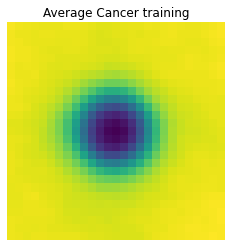

In [873]:
#defining a function to calculate the mean, variance, SD image of a dataset
import numpy as np
def find_mean_img(dataframe, title, size = (27, 27)):
    mean_img = np.mean(dataframe, axis=0)
    #print(mean_img)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img)
    plt.title(f'Average{title}')
    plt.axis('off')
    plt.show()
    return mean_img

def find_vari_img(dataframe, title, size = (27, 27)):
    vari_img = np.var(dataframe, axis=0)
    vari_img = vari_img.reshape(size)
    plt.imshow(vari_img)
    plt.title(f'Variance {title}')
    plt.axis('off')
    plt.show()
    return vari_img

def find_std_img(dataframe, title, size = (27, 27)):
    std_img = np.std(dataframe, axis = 0)
    std_img = std_img.reshape(size)
    plt.imshow(std_img)
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img
    

#The mean image of the cancer_data set
cancer_train_mean = find_mean_img(cancer_train_X, ' Cancer training' )

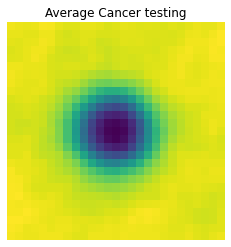

In [874]:
#check if the extra data has a different average image than the other dataset
cancer_test_mean = find_mean_img(cancer_test_X, ' Cancer testing' )

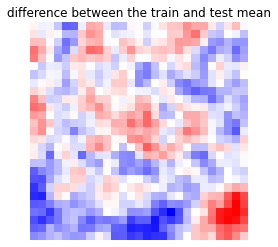

In [875]:
#showing the contrast between each image
contrast_mean = cancer_train_mean - cancer_test_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'difference between the train and test mean')
plt.axis('off')
plt.show()

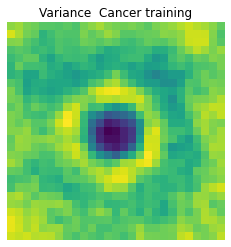

In [876]:
cancer_train_vari = find_vari_img(cancer_train_X, ' Cancer training' )

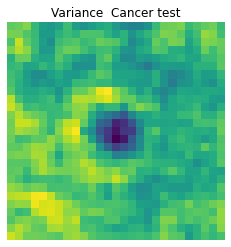

In [877]:
cancer_test_vari = find_vari_img(cancer_test_X, ' Cancer test' )

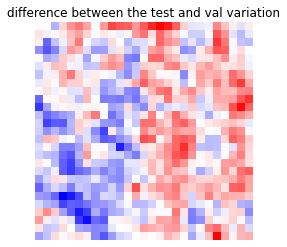

In [878]:
contrast_vari = cancer_train_vari - cancer_test_vari
plt.imshow(contrast_vari, cmap='bwr')
plt.title(f'difference between the test and val variation')
plt.axis('off')
plt.show()

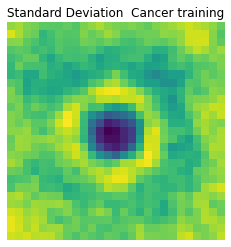

In [879]:
cancer_train_std = find_std_img(cancer_train_X, ' Cancer training' )

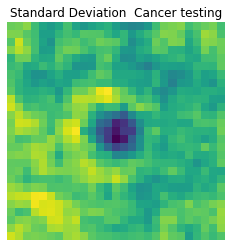

In [880]:
cancer_test_std = find_std_img(cancer_test_X, ' Cancer testing' )

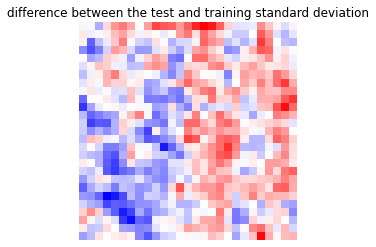

In [881]:
contrast_std = cancer_train_std - cancer_test_std
plt.imshow(contrast_std, cmap='bwr')
plt.title(f'difference between the test and training standard deviation')
plt.axis('off')
plt.show()

(7916, 729)
Number of PC:  32


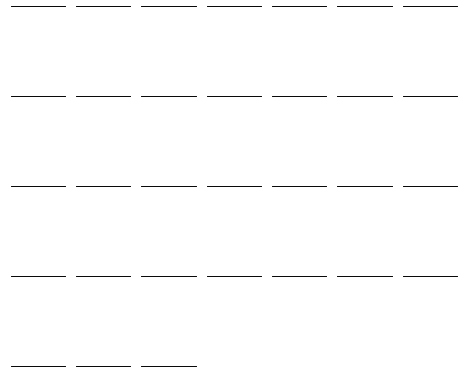

In [882]:
from sklearn.decomposition import PCA
from math import ceil

def eigen_images(dataframe, title, n_comp):
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(dataframe)
    print('Number of PC: ', pca.n_components_)
    return pca

def plot_pca(pca, size = (27, 27)):
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(np.expand_dims(pca.components_[i], axis=0), cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
samples, x, y = cancer_train_X.shape
train_cancer_X = cancer_train_X.reshape((samples, x*y))

samples, x, y = cancer_test_X.shape
test_cancer_X = cancer_test_X.reshape((samples, x*y))

samples, x, y = cell_train_X.shape
train_cell_X = cell_train_X.reshape((samples, x*y))

samples, x, y = cell_test_X.shape
test_cell_X = cell_test_X.reshape((samples, x*y))
#print(train_cell_X.shape)
#train_cell_X = cancer_train_X.flatten()
print(train_cell_X.shape)
plot_pca(eigen_images(train_cell_X, 'cancerData', 0.7))

In [883]:
from skimage import filters
curr_img = np.reshape(cancer_train_X[0], size)
edge_h = filters.sobel_h(curr_img)
edge_v = filters.sobel_v(curr_img)

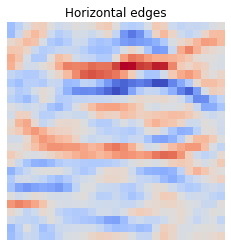

In [884]:
plt.imshow(edge_h, cmap=plt.cm.coolwarm)
plt.axis('off')
plt.title("Horizontal edges")
plt.show()

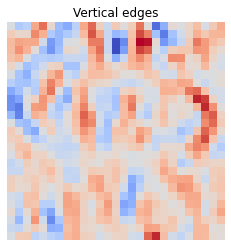

In [885]:
plt.imshow(edge_v, cmap=plt.cm.coolwarm)
plt.axis('off')
plt.title("Vertical edges")
plt.show()

### Cancer data PCA and TSNE

In [886]:
#Create the PCA and reduce to 3 dimensions, and put it into a dataframe
from sklearn.decomposition import PCA
#flatten the images to 2D for PCA
#pca_X_train = cl_X_train.reshape(32,3*27*27)
#pca_y_train = np.prod(cl_y_train.shape)

pca = PCA(n_components = 3)
pca.fit(train_cancer_X)
pca_reduc_x = pca.transform(train_cell_X)
pca_df = pd.DataFrame()
pca_df['y'] = cancer_train_y.flatten()
pca_df['pca1'] = pca_reduc_x[:,0]
pca_df['pca2'] = pca_reduc_x[:,1]
pca_df['pca3'] = pca_reduc_x[:,2]


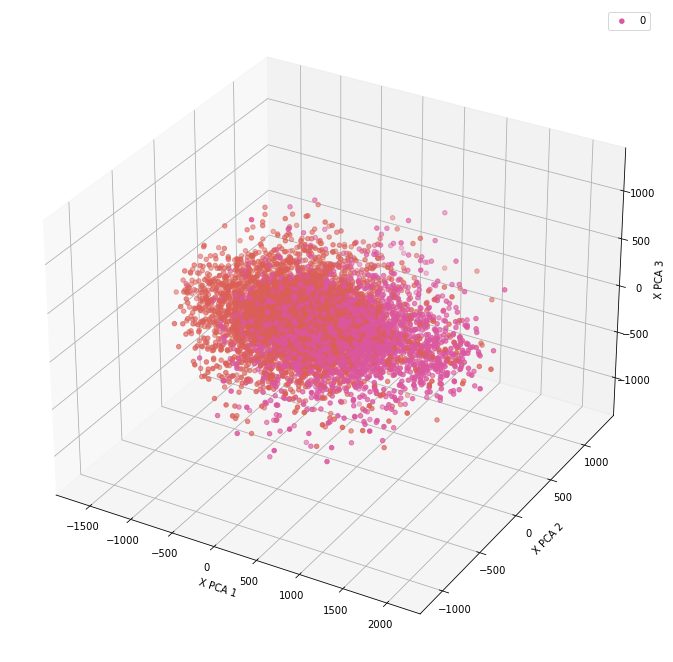

In [887]:
#create scatterplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
fig = plt.figure(figsize=(9,9))

ax = Axes3D(fig)
ax.scatter(pca_reduc_x[:,0], pca_reduc_x[:,1], pca_reduc_x[:,2] ,
           c=cancer_train_y, marker='o',\
           cmap=ListedColormap(sns.color_palette("hls", 10)))
ax.set_xlabel('X PCA 1')
ax.set_ylabel('X PCA 2')
ax.set_zlabel('X PCA 3')
plt.legend(labels=["0","1"])
plt.show()

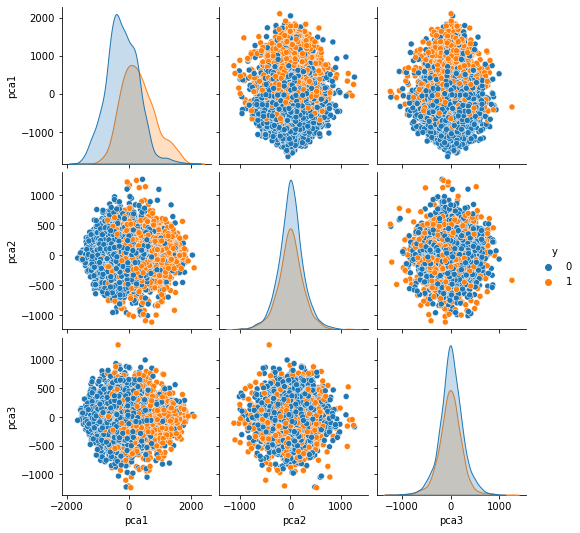

In [888]:
#A pairwise plot of the same data
sns.pairplot(pca_df, hue='y')

In [889]:
#try a 2D reduction and plot the results
pca2d = PCA(n_components=2)
pca2d.fit(train_cancer_X)
pca_reduc_2d_x = pca.transform(train_cancer_X)
pca_df_2d = pd.DataFrame()
pca_df_2d['y'] = cancer_train_y.flatten()
pca_df_2d['pca1'] = pca_reduc_2d_x[:,0]
pca_df_2d['pca2'] = pca_reduc_2d_x[:,1]


Text(0.5, 1.0, 'PCA (n=2) Reduced X Set by Target Label')

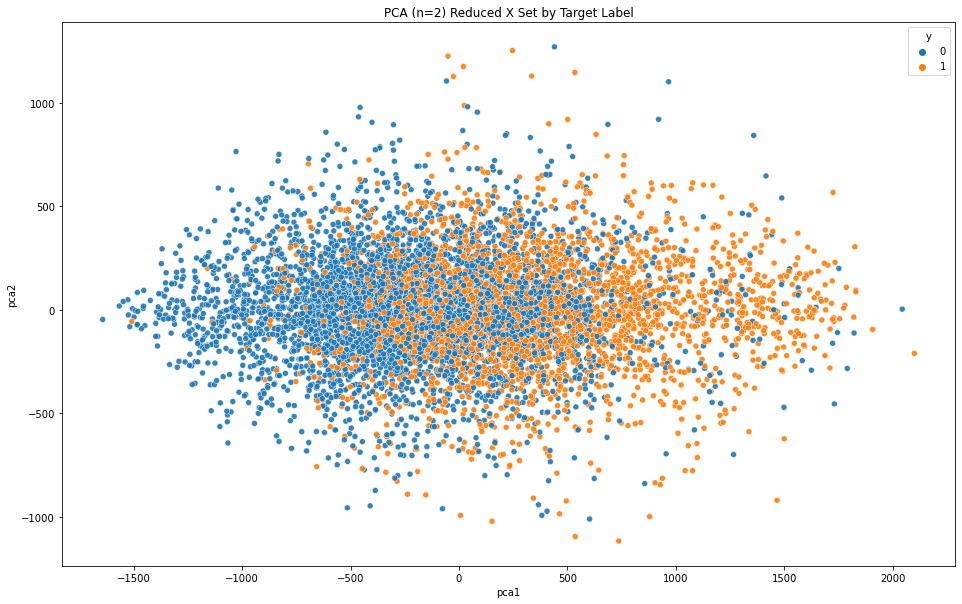

In [890]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="y",
    data=pca_df_2d,
    legend="full",
    alpha=0.9
).set_title('PCA (n=2) Reduced X Set by Target Label')

In [891]:
#creating a 3 component TSNE reduction
from sklearn.manifold import TSNE
tsne_X3 =  TSNE(n_components = 3).fit_transform(train_cancer_X)

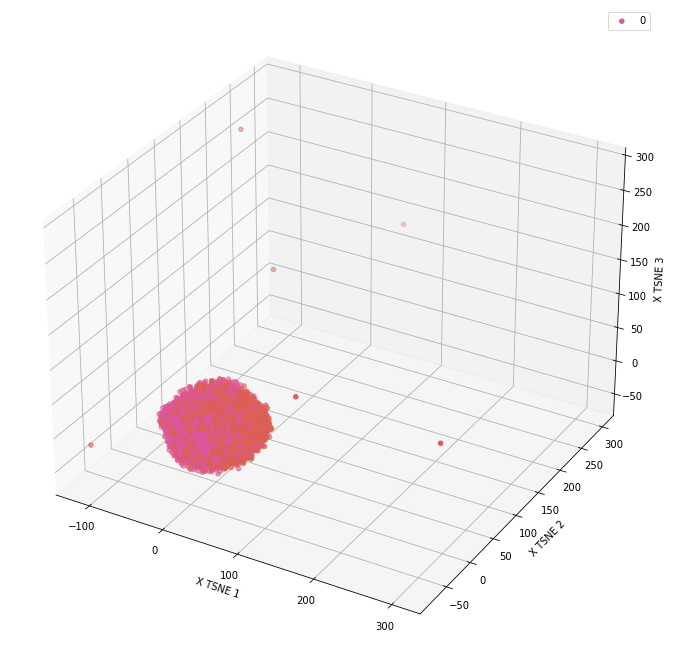

In [892]:
#plotting the 3D TSNE
fig = plt.figure(figsize=(9,9))

ax = Axes3D(fig)
ax.scatter(tsne_X3[:,0], tsne_X3[:,1], tsne_X3[:,2] ,\
           c=cancer_train_y, marker='o',\
           cmap=ListedColormap(sns.color_palette("hls", 10)))
ax.set_xlabel('X TSNE 1')
ax.set_ylabel('X TSNE 2')
ax.set_zlabel('X TSNE 3')
plt.legend(labels=["0","1"])
plt.show()

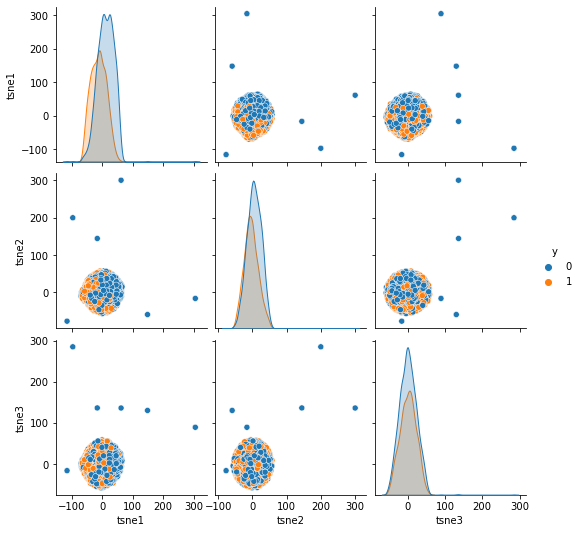

In [893]:
#pairwise plot
reduced_3d = pd.DataFrame()
reduced_3d['y'] = cancer_train_y.flatten()
reduced_3d['tsne1'] = tsne_X3[:,0]
reduced_3d['tsne2'] = tsne_X3[:,1] 
reduced_3d['tsne3'] = tsne_X3[:,2] 

sns.pairplot(reduced_3d, hue='y')

In [894]:
#Trying a T-SNE manifold reduction

tsne_X = TSNE(n_components=2,n_iter=2500,perplexity=30,learning_rate=200,angle=0.2).fit_transform(train_cancer_X)

In [895]:
reduced_2d = pd.DataFrame()
reduced_2d['y'] = cancer_train_y.flatten()
reduced_2d['tsne1'] = tsne_X[:,0]
reduced_2d['tsne2'] = tsne_X[:,1] 

Text(0.5, 1.0, 'TSNE (n=2) Reduced X Set by Target Label')

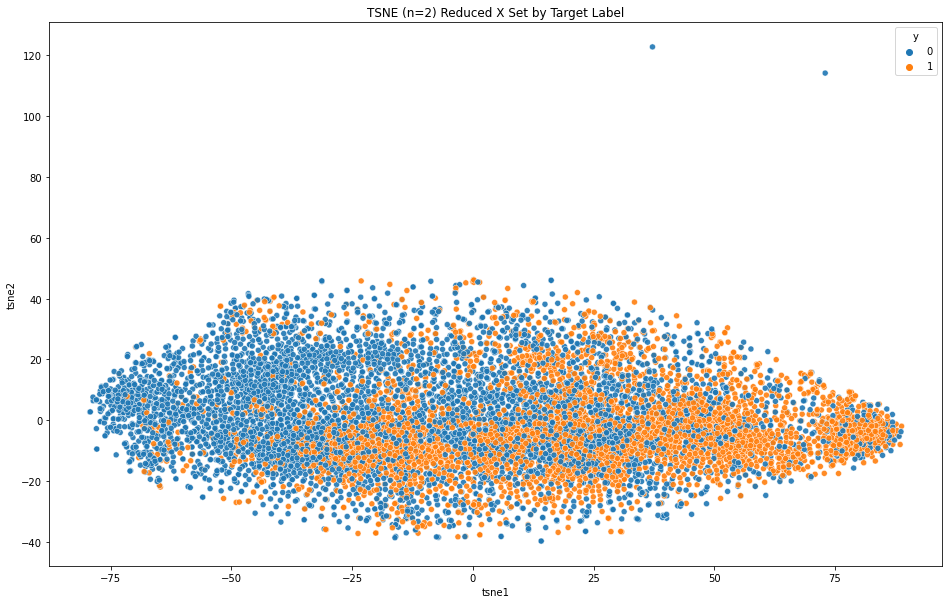

In [896]:
#plotting
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="y",
    data=reduced_2d,
    legend="full",
    alpha=0.9
).set_title('TSNE (n=2) Reduced X Set by Target Label')

### Cell type PCA and TNSE

In [897]:
#Create the PCA and reduce to 3 dimensions, and put it into a dataframe
pca = PCA(n_components = 3)
pca.fit(train_cell_X)
pca_reduc_x = pca.transform(train_cell_X)
pca_df = pd.DataFrame()
pca_df['y'] = cell_train_y.flatten()
pca_df['pca1'] = pca_reduc_x[:,0]
pca_df['pca2'] = pca_reduc_x[:,1]
pca_df['pca3'] = pca_reduc_x[:,2]

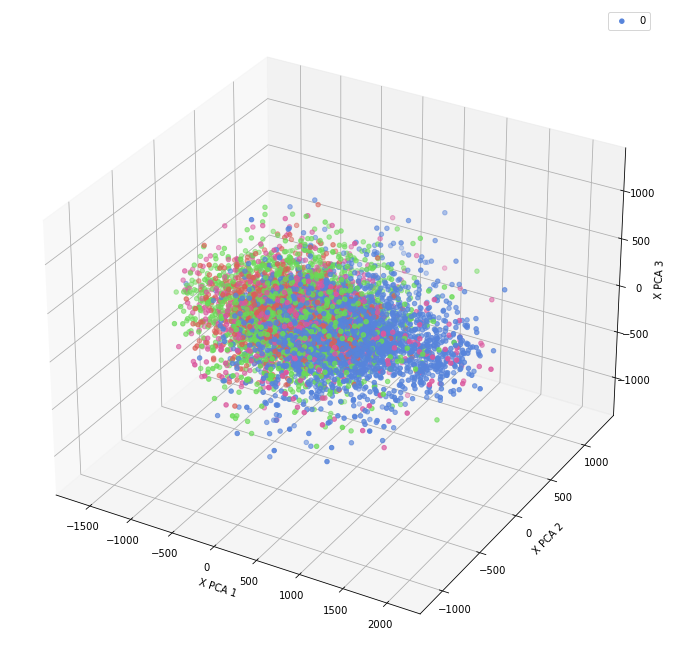

In [898]:
#create scatterplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
fig = plt.figure(figsize=(9,9))

ax = Axes3D(fig)
ax.scatter(pca_reduc_x[:,0], pca_reduc_x[:,1], pca_reduc_x[:,2] ,
           c=cell_train_y, marker='o',\
           cmap=ListedColormap(sns.color_palette("hls", 10)))
ax.set_xlabel('X PCA 1')
ax.set_ylabel('X PCA 2')
ax.set_zlabel('X PCA 3')
plt.legend(labels=["0","1"])
plt.show()

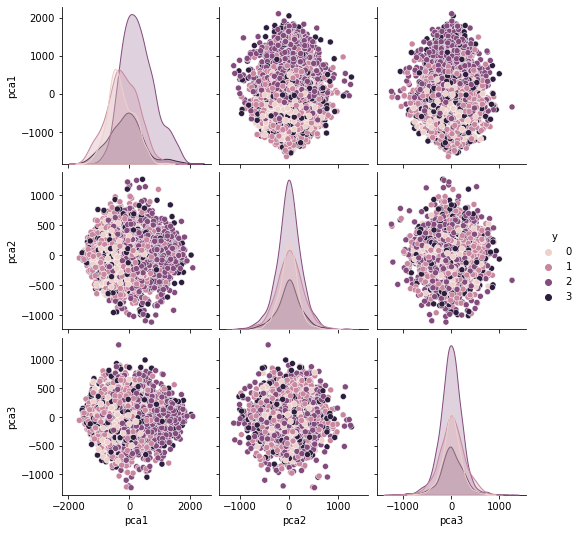

In [899]:
#A pairwise plot of the same data
sns.pairplot(pca_df, hue='y')

In [900]:
#try a 2D reduction and plot the results
pca2d = PCA(n_components=2)
pca2d.fit(train_cell_X)
pca_reduc_2d_x = pca.transform(train_cell_X)
pca_df_2d = pd.DataFrame()
pca_df_2d['y'] = cell_train_y.flatten()
pca_df_2d['pca1'] = pca_reduc_2d_x[:,0]
pca_df_2d['pca2'] = pca_reduc_2d_x[:,1]

Text(0.5, 1.0, 'PCA (n=2) Reduced X Set by Target Label')

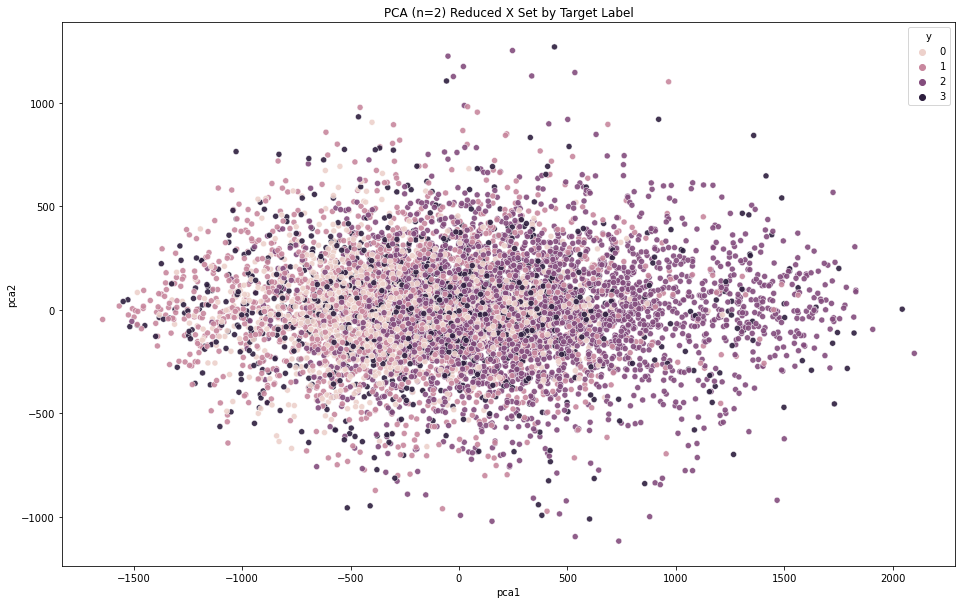

In [901]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="y",
    data=pca_df_2d,
    legend="full",
    alpha=0.9
).set_title('PCA (n=2) Reduced X Set by Target Label')

In [902]:
#creating a 3 component TSNE reduction
tsne_X3 =  TSNE(n_components = 3).fit_transform(train_cell_X)

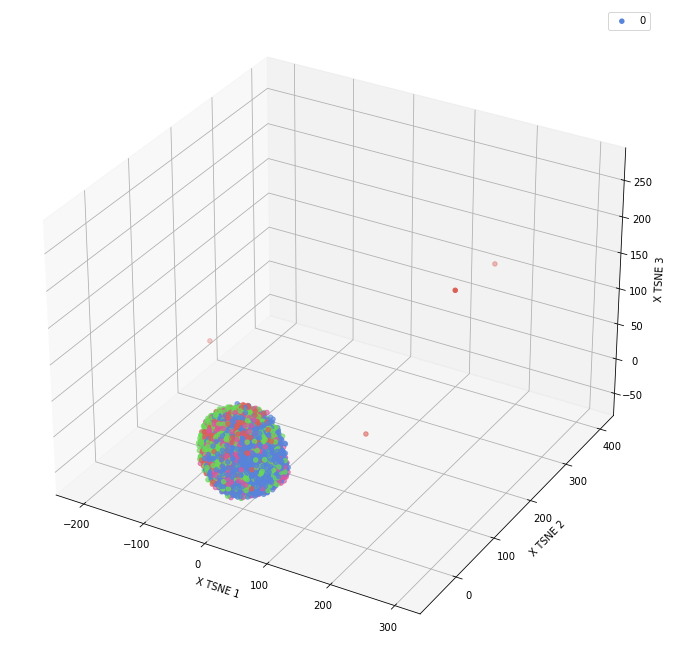

In [903]:
#plotting the 3D TSNE
fig = plt.figure(figsize=(9,9))

ax = Axes3D(fig)
ax.scatter(tsne_X3[:,0], tsne_X3[:,1], tsne_X3[:,2] ,\
           c=cell_train_y, marker='o',\
           cmap=ListedColormap(sns.color_palette("hls", 10)))
ax.set_xlabel('X TSNE 1')
ax.set_ylabel('X TSNE 2')
ax.set_zlabel('X TSNE 3')
plt.legend(labels=["0","1"])
plt.show()

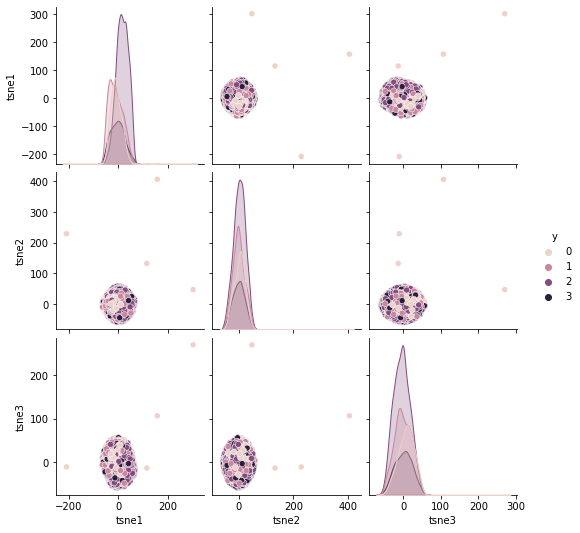

In [904]:
#pairwise plot
reduced_3d = pd.DataFrame()
reduced_3d['y'] = cell_train_y.flatten()
reduced_3d['tsne1'] = tsne_X3[:,0]
reduced_3d['tsne2'] = tsne_X3[:,1] 
reduced_3d['tsne3'] = tsne_X3[:,2] 

sns.pairplot(reduced_3d, hue='y')

In [905]:
#Trying a T-SNE manifold reduction
from sklearn.manifold import TSNE
tsne_X = TSNE(n_components=2,n_iter=2500,perplexity=30,learning_rate=200,angle=0.2).fit_transform(train_cell_X)

In [906]:
reduced_2d = pd.DataFrame()
reduced_2d['y'] = cell_train_y.flatten()
reduced_2d['tsne1'] = tsne_X[:,0]
reduced_2d['tsne2'] = tsne_X[:,1] 

Text(0.5, 1.0, 'TSNE (n=2) Reduced X Set by Target Label')

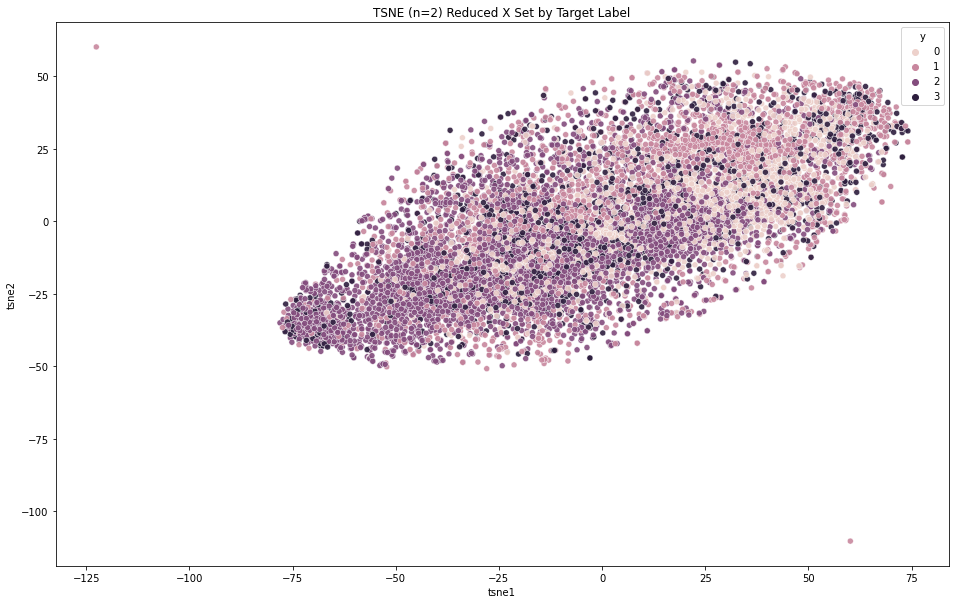

In [907]:
#plotting
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="y",
    data=reduced_2d,
    legend="full",
    alpha=0.9
).set_title('TSNE (n=2) Reduced X Set by Target Label')

# Model Construction


In [908]:
#Defining a function to show a learning curve for the NN
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [909]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB

#Taken from the sklearn documentation, for use with my non-NN models
#Accessed 19/05/2021
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Non-NN classifiers
### isCancerous classifer 
#### SVM classifier

In [910]:
#Flattening the y
cancer_flat_train_y = cancer_train_y.flatten()
cancer_flat_test_y = cancer_test_y.flatten()

<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

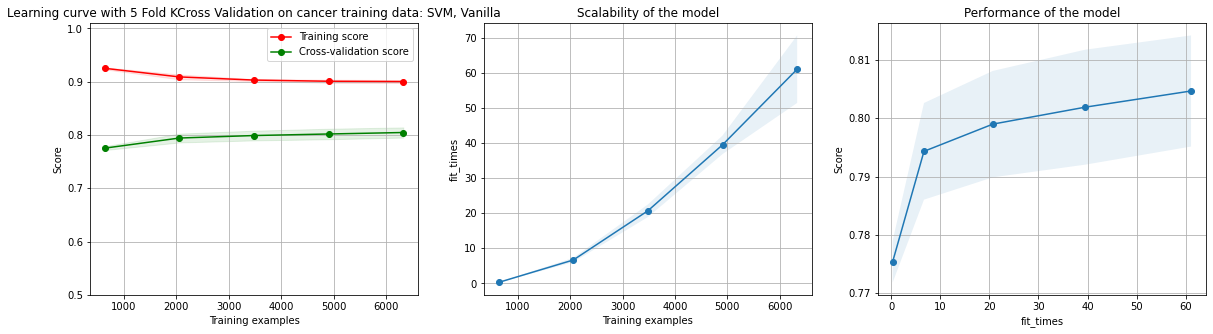

In [911]:
graph_title = "Learning curve with 5 Fold KCross Validation on cancer training data: SVM, Vanilla"
pipe = Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC())])
plot_learning_curve(pipe, graph_title, train_cancer_X, cancer_flat_train_y, 
                   ylim=(0.5, 1.01), cv = 5, n_jobs=-1)

In [912]:
#SVM grid search for the best parameters

from sklearn import neighbors, neural_network, svm, utils
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (GridSearchCV, learning_curve, ShuffleSplit, validation_curve)


pipe = Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC())])

Cs = [0.001,0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['rbf','linear', 'poly', 'sigmoid'] 
param_grid = {'SVM__C': Cs, 'SVM__gamma' : gammas, 'SVM__kernel' : kernels}
grid_search = GridSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(train_cancer_X, cancer_flat_train_y)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'SVM__C': 1, 'SVM__gamma': 0.001, 'SVM__kernel': 'rbf'}


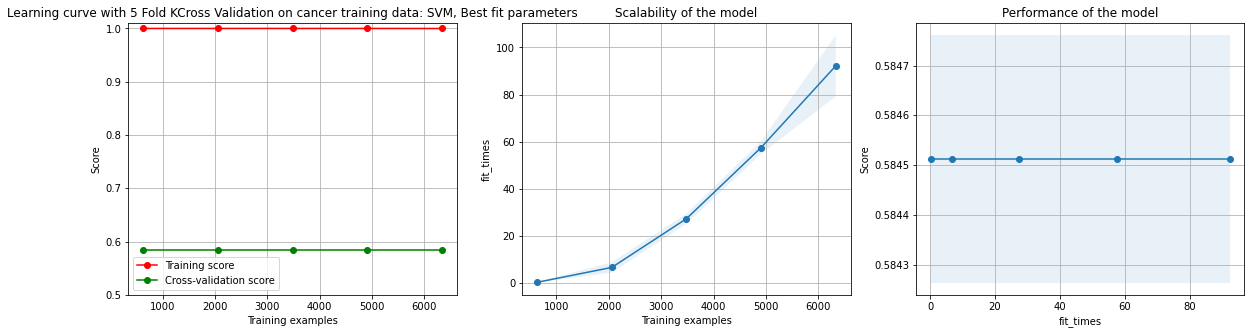

In [913]:
#plotting the learning curve of the grid searched best parameters
graph_title = "Learning curve with 5 Fold KCross Validation on cancer training data: SVM, Best fit parameters"

svm_cancer = svm.SVC(C = 1, gamma=0.001, kernel='rbf')
pipe = Pipeline([('scaler', StandardScaler()), ('SVM', svm_cancer)])
plot_learning_curve(svm_cancer, graph_title, train_cancer_X, cancer_flat_train_y,
                    ylim = (0.5, 1.01), cv = 5, n_jobs=-1)
plt.show()

#### K-nearest neighbours classifier

<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

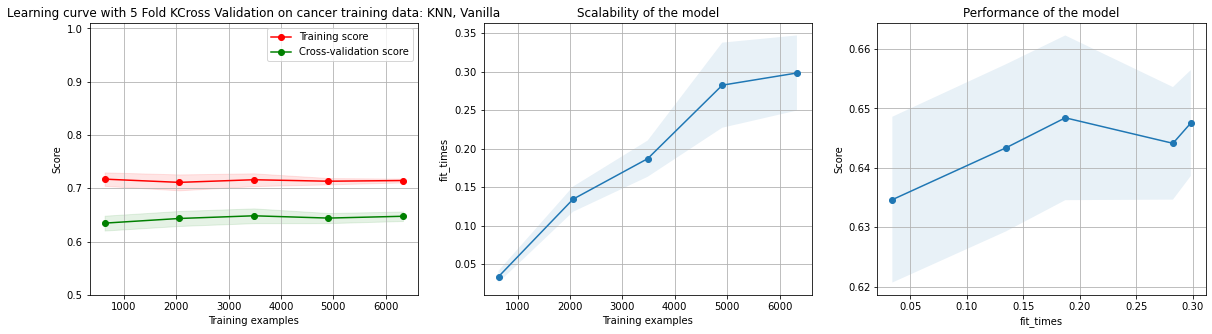

In [914]:
graph_title = "Learning curve with 5 Fold KCross Validation on cancer training data: KNN, Vanilla"
pipe = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])
plot_learning_curve(pipe, graph_title, train_cancer_X, cancer_flat_train_y, ylim = (0.5, 1.01), cv = 5, n_jobs=-1)

In [915]:
from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())]) 

neighbors = [3,5,7,9,11]
weights = ['uniform', 'distance']
algorithms = ['ball_tree', 'kd_tree', 'brute']
metrics = ['euclidean','manhattan', 'minkowski'] 


param_grid = {'KNN__n_neighbors': neighbors, 'KNN__weights' : weights, 'KNN__algorithm' : algorithms,
              'KNN__metric' : metrics}
grid_search = GridSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(train_cancer_X, cancer_flat_train_y)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'KNN__algorithm': 'ball_tree', 'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11, 'KNN__weights': 'distance'}


<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

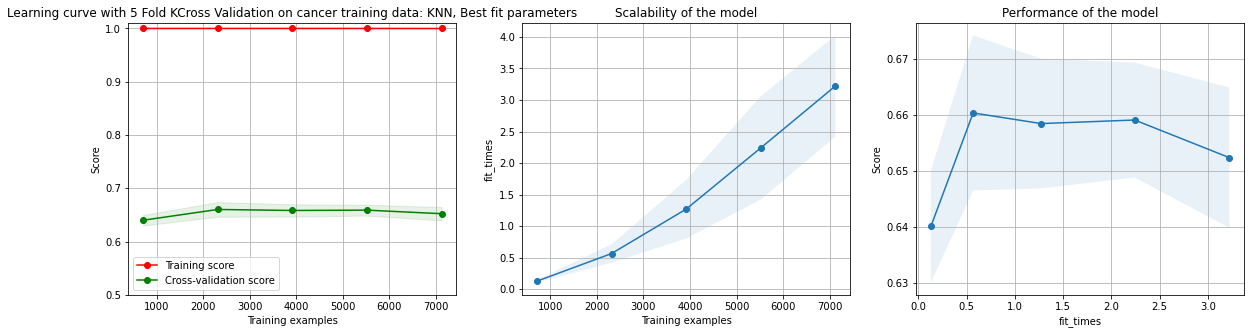

In [916]:
graph_title = "Learning curve with 5 Fold KCross Validation on cancer training data: KNN, Best fit parameters"
knn_cancer = KNeighborsClassifier(algorithm = 'ball_tree', metric = 'manhattan',
                                 n_neighbors = 11, weights = 'distance')
pipe = Pipeline([('scaler', StandardScaler()), ('KNN', knn_cancer)])
plot_learning_curve(pipe, graph_title, train_cancer_X, cancer_flat_train_y,
                    ylim = (0.5, 1.01), cv = 10, n_jobs=-1)

#### Random forest classifer 

In [917]:
from sklearn.ensemble import RandomForestClassifier 

<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

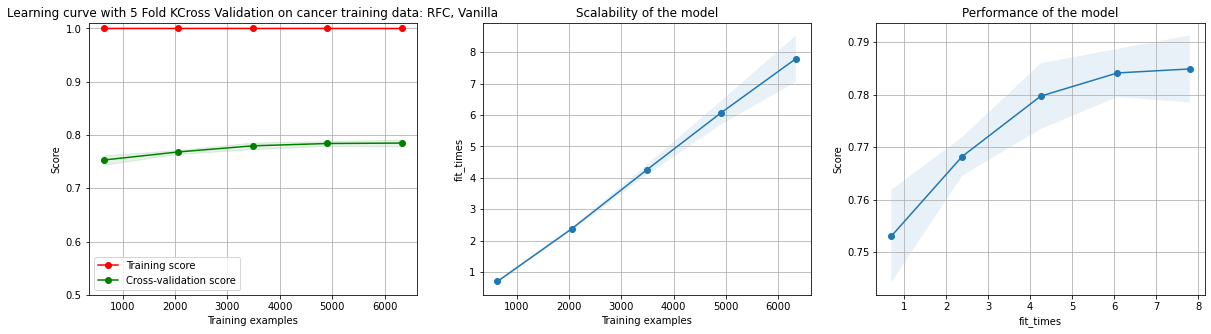

In [918]:
graph_title = "Learning curve with 5 Fold KCross Validation on cancer training data: RFC, Vanilla"
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier())])
plot_learning_curve(pipe, graph_title, train_cancer_X, cancer_flat_train_y,
                    ylim = (0.5, 1.01), cv = 5, n_jobs=-1)

In [919]:
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier())])
estimators = [10,50,100,200,300,400,1000,2000]
param_grid = {'RFC__n_estimators' : estimators }
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=8, scoring='accuracy', verbose=2)
grid_search.fit(train_cancer_X, cancer_flat_train_y)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'RFC__n_estimators': 1000}


<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

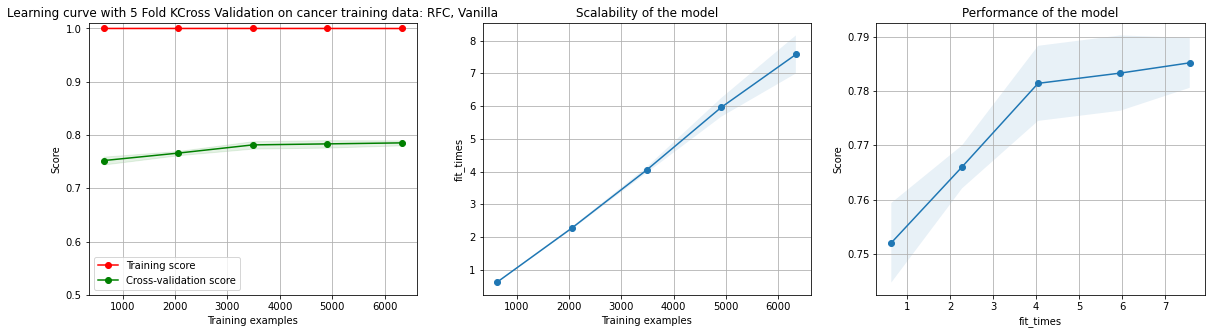

In [920]:
graph_title = "Learning curve with 5 Fold KCross Validation on cancer training data: RFC, Vanilla"
rfc_cancer = RandomForestClassifier(n_estimators = 1000)
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', rfc_cancer)])
plot_learning_curve(RandomForestClassifier(), graph_title, train_cancer_X, cancer_flat_train_y,
                    ylim = (0.5, 1.01), cv = 5, n_jobs=-1)

### cellType classifer 
#### SVM classifier 

In [921]:
cell_flat_train_y = cell_train_y.flatten()
cell_flat_test_y = cell_test_y.flatten()

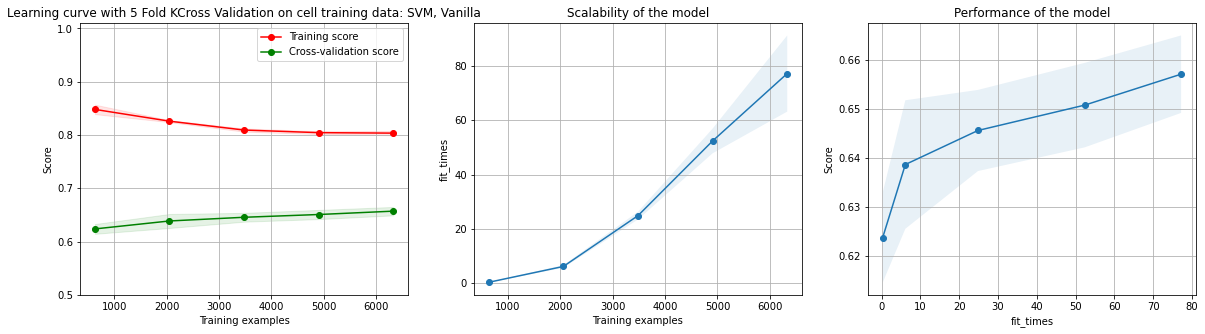

In [922]:
graph_title = "Learning curve with 5 Fold KCross Validation on cell training data: SVM, Vanilla"
pipe = Pipeline([('scaler', StandardScaler()), ('svm', svm.SVC())])
plot_learning_curve(svm.SVC(), graph_title, train_cell_X, cell_flat_train_y, 
                   ylim=(0.5, 1.01), cv = 5, n_jobs=-1)
plt.show()

In [923]:
#grid search for the cellType SVC
pipe = Pipeline([('scaler', StandardScaler()), ('SVC', svm.SVC())])
gammas = [0.001, 0.01, 0.1, 1]
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['rbf','linear'] 
param_grid = {'SVC__C': Cs, 'SVC__gamma' : gammas, 'SVC__kernel' : kernels}
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=8, scoring='accuracy', verbose=2)
grid_search.fit(train_cell_X, cell_flat_train_y)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'SVC__C': 1, 'SVC__gamma': 0.001, 'SVC__kernel': 'rbf'}


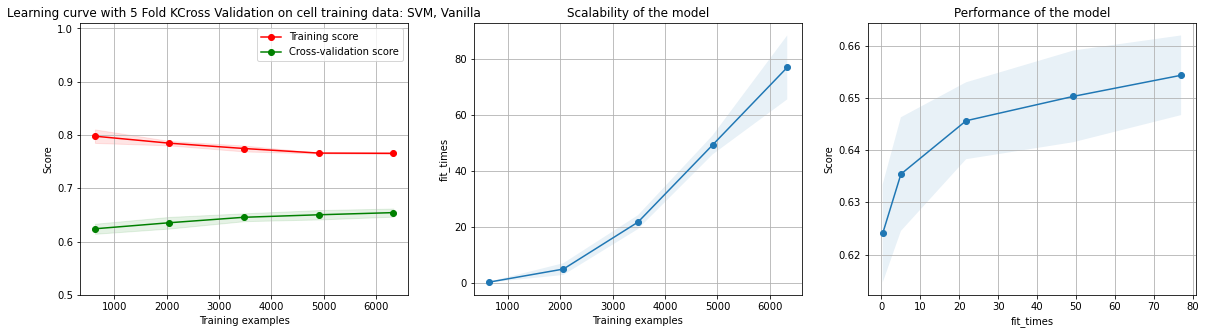

In [924]:
svm_cell = svm.SVC(C = 1, gamma=0.001, kernel='rbf')
pipe = Pipeline([('scaler', StandardScaler()), ('svm', svm_cell)])
plot_learning_curve(pipe, graph_title, train_cell_X, cell_flat_train_y, 
                   ylim=(0.5, 1.01), cv = 5, n_jobs=-1)
plt.show()

#### K-nearest neighbours classifer


<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

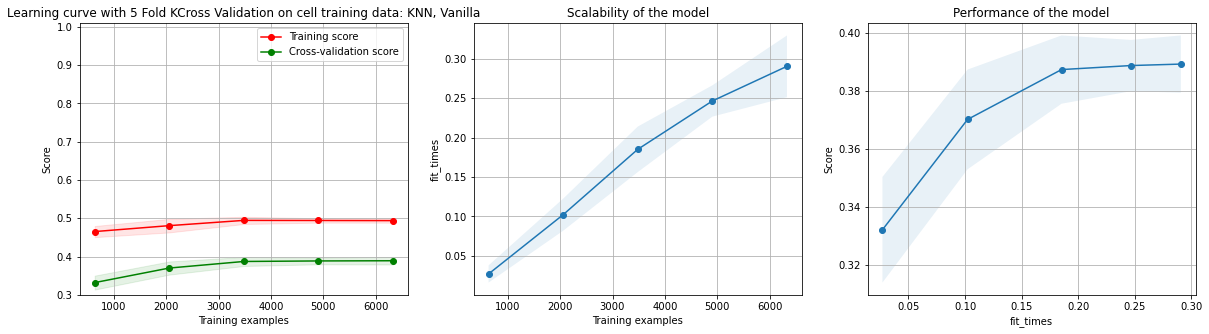

In [925]:
graph_title = "Learning curve with 5 Fold KCross Validation on cell training data: KNN, Vanilla"
pipe = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])
plot_learning_curve(pipe, graph_title, train_cell_X, cell_flat_train_y,
                    ylim = (0.3, 1.01), cv = 5, n_jobs=-1)

In [926]:
#grid search the penalty first
pipe = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])
neighbors = [3, 5, 7, 9, 11, 13, 15]
param_grid = {'KNN__n_neighbors': neighbors}
grid_search = GridSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(train_cell_X, cell_flat_train_y)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'KNN__n_neighbors': 5}


In [927]:
cell_knn = KNeighborsClassifier(n_neighbors = 5)
pipe = Pipeline([('scaler', StandardScaler()), ('KNN', cell_knn)])
#neighbors = [3,5,7,9,11]
weights = ['uniform', 'distance']
algorithms = ['ball_tree', 'kd_tree', 'brute']
metrics = ['euclidean','manhattan', 'minkowski'] 


param_grid = {'KNN__weights' : weights, 'KNN__algorithm' : algorithms,
              'KNN__metric' : metrics}
grid_search = GridSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(train_cell_X, cell_flat_train_y)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'KNN__algorithm': 'ball_tree', 'KNN__metric': 'manhattan', 'KNN__weights': 'distance'}


<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

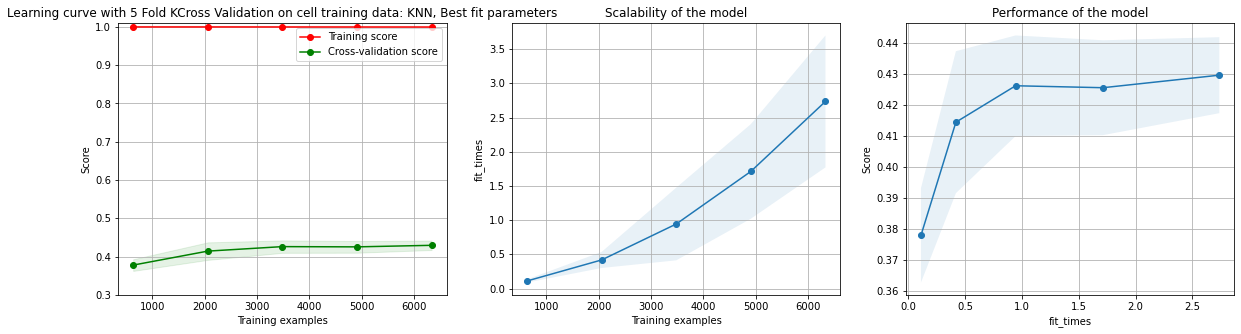

In [928]:
graph_title = "Learning curve with 5 Fold KCross Validation on cell training data: KNN, Best fit parameters"
cell_knn = KNeighborsClassifier(algorithm = 'ball_tree', metric = 'manhattan',
                               n_neighbors = 5, weights = 'distance')
pipe = Pipeline([('scaler', StandardScaler()), ('KNN', cell_knn)])
plot_learning_curve(pipe, graph_title, train_cell_X, cell_flat_train_y,
                    ylim = (0.3, 1.01), cv = 5, n_jobs=-1)

#### Random forest classifier

<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

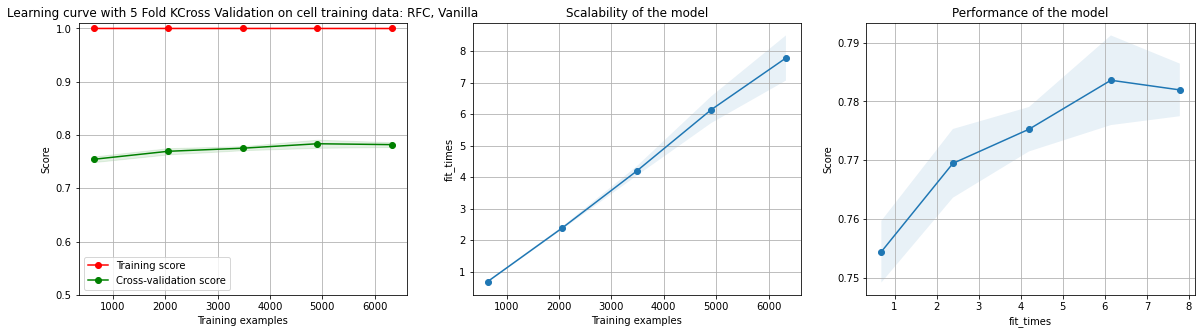

In [929]:
graph_title = "Learning curve with 5 Fold KCross Validation on cell training data: RFC, Vanilla"
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier())])
plot_learning_curve(pipe, graph_title, train_cell_X, cancer_flat_train_y, ylim = (0.5, 1.01), cv = 5, n_jobs=-1)

In [930]:
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier())])
estimators = [10,50,100,200,300,400,1000,2000]
param_grid = {'RFC__n_estimators' : estimators}
grid_search = GridSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(train_cell_X, cell_flat_train_y)
grid_search.best_params_
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'RFC__n_estimators': 2000}


<module 'matplotlib.pyplot' from 'C:\\Users\\Rhys\\anaconda3\\envs\\py3\\lib\\site-packages\\matplotlib\\pyplot.py'>

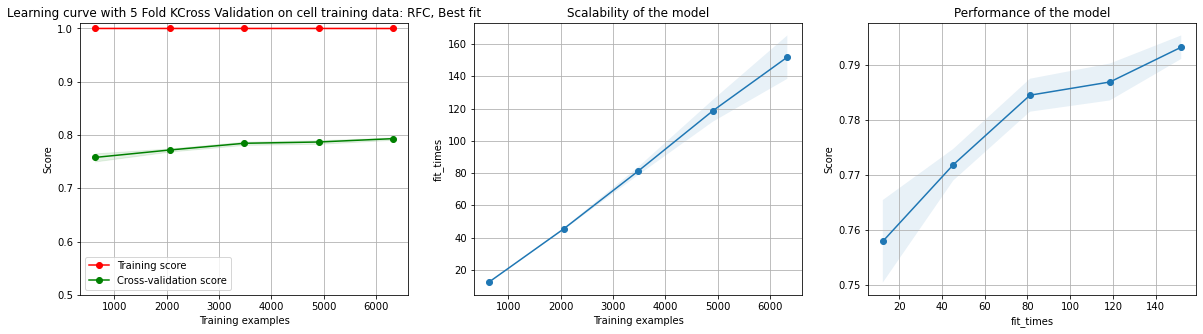

In [931]:
graph_title = "Learning curve with 5 Fold KCross Validation on cell training data: RFC, Best fit"
rfc_cell = RandomForestClassifier(n_estimators = 2000)
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', rfc_cell)])
plot_learning_curve(pipe, graph_title, train_cancer_X, cancer_flat_train_y,
                    ylim = (0.5, 1.01), cv = 5, n_jobs=-1)

## Neural network classifiers
### isCancerous Classifer

In [932]:
def plot_curve(c):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(c.history['loss'], 'r--')
    plt.plot(c.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(c.history['accuracy'], 'r--')
    plt.plot(c.history['val_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.show()

In [933]:
# Based on these results, it seems a 6x complexity on a non-augmented dataset, we can adjust the ridge penelty and see if we can fix the underfitting
comp = 6
reg_lambda = 0.1

cnn_cc = Sequential()
cnn_cc.add(Conv2D(8*comp, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_cc.add(MaxPooling2D(pool_size=(2,2)))
cnn_cc.add(Dropout(0.2))

cnn_cc.add(Conv2D(16*comp, kernel_size=(3,3), activation='relu'))
cnn_cc.add(MaxPooling2D(pool_size=(2,2)))
cnn_cc.add(Dropout(0.2))

cnn_cc.add(Conv2D(32*comp, kernel_size=(3,3), activation='relu'))
cnn_cc.add(MaxPooling2D(pool_size=(2,2)))
cnn_cc.add(Dropout(0.2))

cnn_cc.add(Flatten())
cnn_cc.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
cnn_cc.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

cnn_cc.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [934]:
cl = cnn_cc.fit(cc_aug_train_generator, validation_data = cc_aug_validation_generator, epochs=50, verbose=0)

In [935]:
#Start with a few base line models to see if we can improve upon them
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

input_shape = (27, 27, 3)


cnn_s = Sequential()
cnn_s.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_s.add(MaxPooling2D(pool_size=(2,2)))
cnn_s.add(Dropout(0.2))
cnn_s.add(Flatten())
cnn_s.add(Dense(128, activation='relu'))
cnn_s.add(Dense(2, activation='softmax'))

cnn_s.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [936]:
single = cnn_d.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

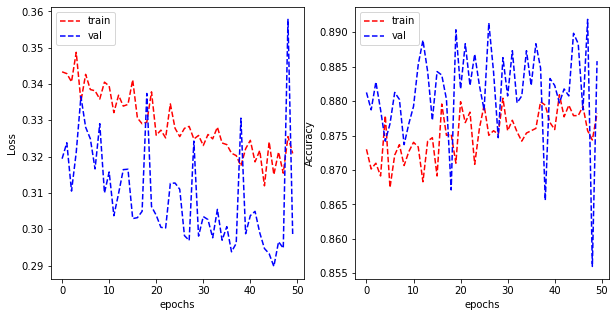

In [937]:
plot_curve(single)

In [938]:
#adding a second layer before regularization to see if we can get any improvements
cnn_d = Sequential()
cnn_d.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_d.add(MaxPooling2D(pool_size=(2,2)))
cnn_d.add(Dropout(0.2))

cnn_d.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
cnn_d.add(MaxPooling2D(pool_size=(2, 2)))
cnn_d.add(Dropout(0.2))

cnn_d.add(Flatten())
cnn_d.add(Dense(128, activation='relu'))
cnn_d.add(Dense(2, activation='softmax'))

cnn_d.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [939]:
double = cnn_d.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

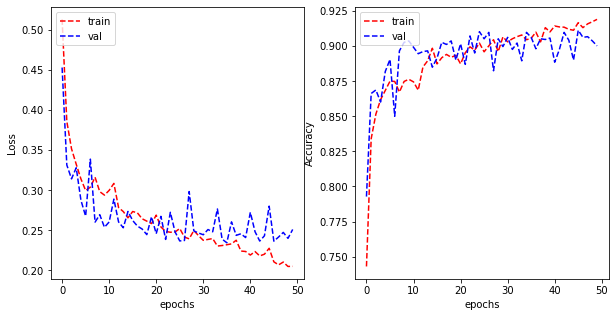

In [940]:
plot_curve(double)

In [941]:
#Checking if a third layer adds any significant performance increases
cnn_t = Sequential()
cnn_t.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
cnn_t.add(Dropout(0.2))

cnn_t.add(Flatten())
cnn_t.add(Dense(128, activation='relu'))
cnn_t.add(Dense(2, activation='softmax'))

cnn_t.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [942]:
triple = cnn_t.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

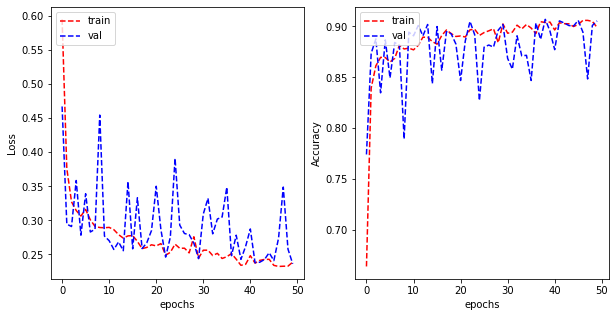

In [943]:
plot_curve(triple)

In [944]:
#trying with another pooling layer
cnn_q = Sequential()
cnn_q.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_q.add(MaxPooling2D(pool_size=(2,2)))
cnn_q.add(Dropout(0.2))

cnn_q.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn_q.add(MaxPooling2D(pool_size=(2,2)))
cnn_q.add(Dropout(0.2))

cnn_q.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
cnn_q.add(MaxPooling2D(pool_size=(2,2)))
cnn_q.add(Dropout(0.2))

cnn_q.add(Flatten())
cnn_q.add(Dense(128, activation='relu'))
cnn_q.add(Dense(2, activation='softmax'))

cnn_q.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [945]:
quad = cnn_q.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

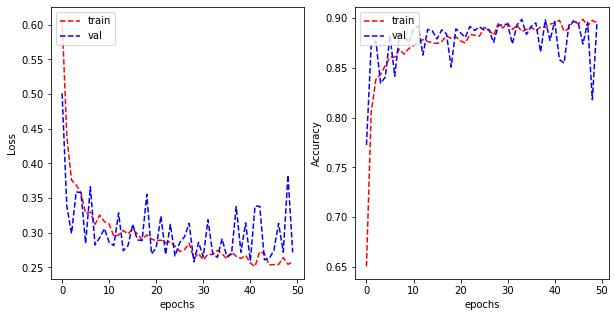

In [946]:
plot_curve(quad)

In [947]:
reg_lambda = 0.001
cnn_q = Sequential()
cnn_q.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_q.add(MaxPooling2D(pool_size=(2,2)))
cnn_q.add(Dropout(0.2))

cnn_q.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn_q.add(MaxPooling2D(pool_size=(2,2)))
cnn_q.add(Dropout(0.2))

cnn_q.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
cnn_q.add(MaxPooling2D(pool_size=(2,2)))
cnn_q.add(Dropout(0.2))

cnn_q.add(Flatten())
#cnn_q.add(Dense(128, activation='relu'))
#cnn_q.add(Dense(2, activation='softmax'))

cnn_q.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
cnn_q.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

cnn_q.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [948]:
quad = cnn_q.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

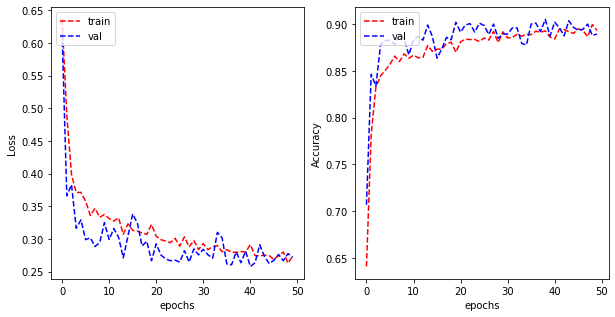

In [949]:
#l2, 0.001
plot_curve(quad)

In [950]:
#try a second layer regularization
reg_lambda = 0.1
cnn_d = Sequential()
cnn_d.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_d.add(MaxPooling2D(pool_size=(2,2)))
cnn_d.add(Dropout(0.2))

cnn_d.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
cnn_d.add(MaxPooling2D(pool_size=(2, 2)))
cnn_d.add(Dropout(0.2))

cnn_d.add(Flatten())
cnn_d.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
cnn_d.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

cnn_d.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [951]:
double_reg = cnn_d.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

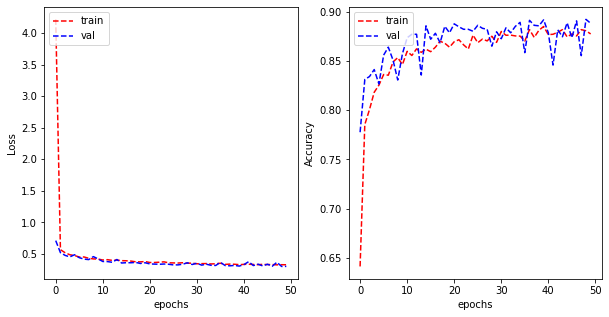

In [952]:
#0.1
plot_curve(double_reg)

In [953]:
#The models are still slightly underfitting, so we can try to regularize via image augmentation
#Since our images seem to 
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', horizontal_flip =True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', horizontal_flip =True, vertical_flip=True)

batch_size = 32

cc_aug_train_generator = train_datagen.flow_from_dataframe(
        dataframe=cc_train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cc_aug_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=cc_val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [954]:
quad = cnn_q.fit(cc_aug_train_generator, validation_data = cc_aug_validation_generator, epochs=50, verbose=0)

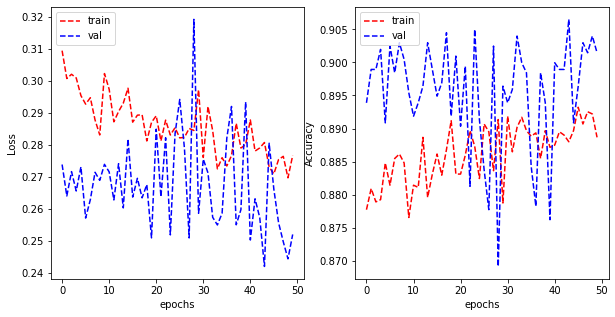

In [955]:
plot_curve(quad)

In [956]:
double_aug = cnn_d.fit(cc_aug_train_generator, validation_data = cc_aug_validation_generator, epochs=50, verbose=0)

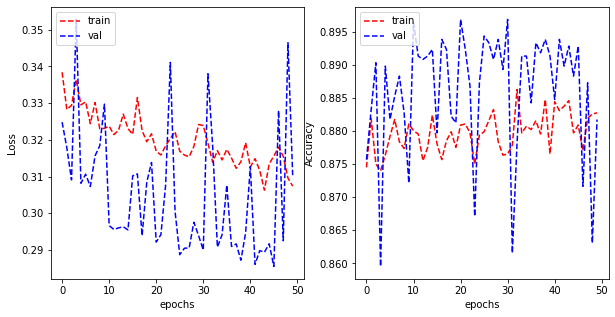

In [957]:
plot_curve(double_aug)

In [958]:
#Search the complexity of the two most promising models
reg_lambda = 0.01
complexity = 6
epochs = 50
tracker = []

for i in range(1, complexity):
    cnn_s = Sequential()
    cnn_s.add(Conv2D(32*i, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Conv2D(16*i, kernel_size=(3,3), activation='relu'))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Conv2D(8*i, kernel_size=(3,3), activation='relu'))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Flatten())
    cnn_s.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
    cnn_s.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

    cnn_s.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    
    log = cnn_s.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=epochs, verbose=0)
    tracker.append((str(i), log))
    

(0.0, 49.0)

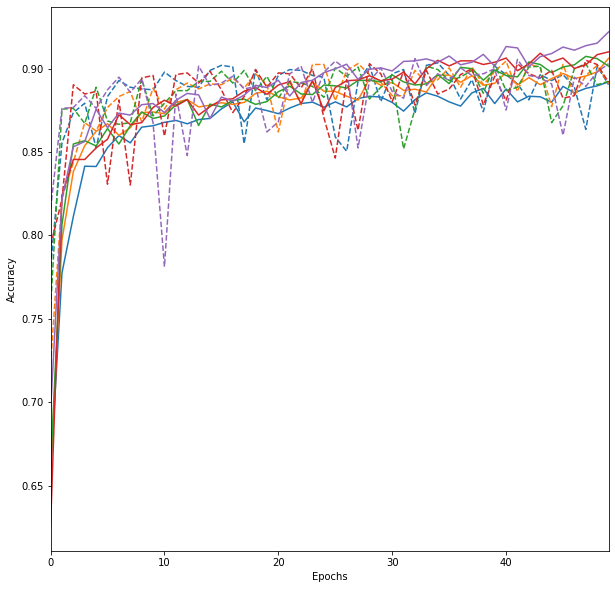

In [959]:
plt.figure(figsize=(10,10))

for count, history in tracker:
    #print(history.history)
    i = int(count)
    cc = (8*i)+(16*i)+(32*i)
    val = plt.plot(history.epoch, history.history['val_'+ 'accuracy'], '--', label=count.title()+' Validation accuracy for '+str(cc)+" total convolutions")
    plt.plot(history.epoch, history.history['accuracy'], 
             color=val[0].get_color(), label= count.title()+' Accuracy for '+str(cc)+" total convolutions")
    

plt.xlabel('Epochs')
plt.ylabel('accuracy'.replace('_', ' ').title())
plt.xlim([0, max(history.epoch)])

blue: Accuracy for 56 total convultions 
blue dotted: Validation Accuracy for 112 total convultions 

orange: Accuracy for 112 total convultions 
O dotted:Validation Accuracy for 112 total convultions 

green: Accuracy for 168 total convultions 
G dotted:Validation Accuracy for 168 total convultions 

red: Accuracy for 224 total convultions 
r dotted: Validation Accuracy for  224 total convultions 

purple: Accuracy for  280 total convultions 
p dotted: Validation Accuracy for 280 total convultions 


In [960]:
reg_lambda = 0.001
comp = 2
cnn_ccf = Sequential()
cnn_ccf.add(Conv2D(32*comp, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_ccf.add(MaxPooling2D(pool_size=(2,2)))
cnn_ccf.add(Dropout(0.2))

cnn_ccf.add(Conv2D(16*comp, kernel_size=(3,3), activation='relu'))
cnn_ccf.add(MaxPooling2D(pool_size=(2,2)))
cnn_ccf.add(Dropout(0.2))

cnn_ccf.add(Conv2D(8*comp, kernel_size=(3,3), activation='relu'))
cnn_ccf.add(MaxPooling2D(pool_size=(2,2)))
cnn_ccf.add(Dropout(0.2))

cnn_ccf.add(Flatten())
cnn_ccf.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
cnn_ccf.add(Dropout(0.2))
cnn_ccf.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
cnn_ccf.add(Dropout(0.2))
cnn_ccf.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

cnn_ccf.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [961]:
fifth = cnn_ccf.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

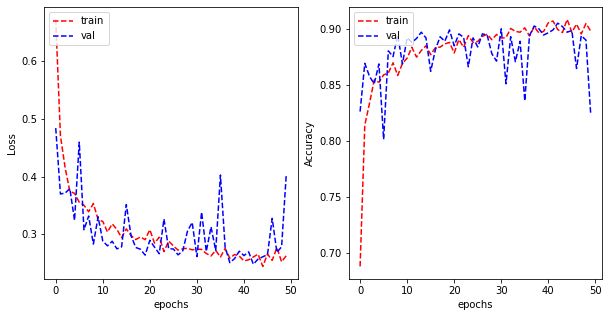

In [962]:
#2 plus dropout
plot_curve(fifth)

In [963]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1)
final_ES = cnn_ccf.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0, 
                  callbacks=[es])

Epoch 00002: early stopping


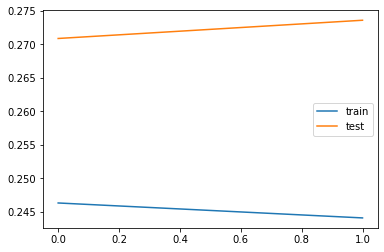

In [964]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [965]:
#grabbing the best model from the fit
mc = ModelCheckpoint('best_model_cc.h5', monitor = 'val_accuracy', mode='max',
                    verbose=1, save_best_only=True)

final_ES = cnn_ccf.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=200, verbose=0, 
                  callbacks=[es, mc])


Epoch 00001: val_accuracy improved from -inf to 0.89843, saving model to best_model_cc.h5

Epoch 00002: val_accuracy improved from 0.89843 to 0.90702, saving model to best_model_cc.h5

Epoch 00003: val_accuracy did not improve from 0.90702
Epoch 00003: early stopping


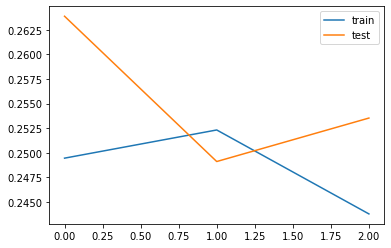

In [966]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [967]:
best_model_cc = load_model('best_model_cc.h5')

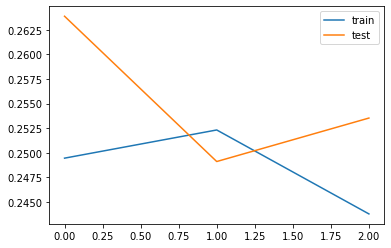

In [968]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [969]:
mc2 = ModelCheckpoint('best_model_cc2.h5', monitor = 'val_accuracy', mode='max',
                    verbose=1, save_best_only=True)


In [970]:
#trying aug dataset
final_ES = cnn_ccf.fit(cc_aug_train_generator, validation_data = cc_aug_validation_generator, epochs=200, verbose=0, 
                  callbacks=[es, mc2])


Epoch 00001: val_accuracy improved from -inf to 0.90045, saving model to best_model_cc2.h5

Epoch 00002: val_accuracy did not improve from 0.90045
Epoch 00002: early stopping


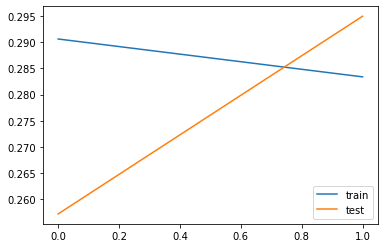

In [971]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [972]:
#This will be the final model unless the two layer version appears to improve
best_model_cc2 = load_model('best_model_cc2.h5')

In [973]:
#search the complexity of the double model
reg_lambda = 0.1
complexity = 6
epochs = 50
tracker = []

for i in range(1, complexity):
    cnn_s = Sequential()
    cnn_s.add(Conv2D(16*i, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Conv2D(8*i, kernel_size=(3,3), activation='relu'))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Flatten())
    cnn_s.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
    cnn_s.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

    cnn_s.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    
    log = cnn_s.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=epochs, verbose=0)
    tracker.append((str(i), log))

(0.0, 49.0)

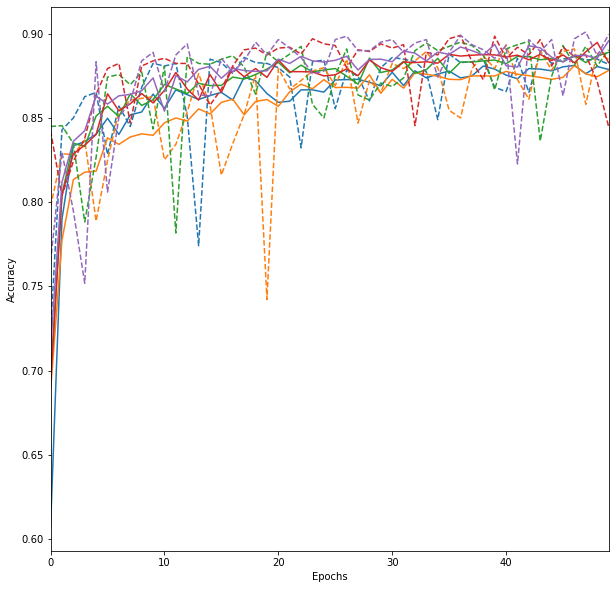

In [974]:
plt.figure(figsize=(10,10))

for count, history in tracker:
    #print(history.history)
    i = int(count)
    cc = (8*i)+(16*i)+(32*i)
    val = plt.plot(history.epoch, history.history['val_'+ 'accuracy'], '--', label=count.title()+' Validation accuracy for '+str(cc)+" total convolutions")
    plt.plot(history.epoch, history.history['accuracy'], 
             color=val[0].get_color(), label= count.title()+' Accuracy for '+str(cc)+" total convolutions")
    

plt.xlabel('Epochs')
plt.ylabel('accuracy'.replace('_', ' ').title())
plt.xlim([0, max(history.epoch)])

blue: Accuracy for 56 total convultions 
blue dotted: Validation Accuracy for 112 total convultions 

orange: Accuracy for 112 total convultions 
O dotted:Validation Accuracy for 112 total convultions 

green: Accuracy for 168 total convultions 
G dotted:Validation Accuracy for 168 total convultions 

red: Accuracy for 224 total convultions 
r dotted: Validation Accuracy for  224 total convultions 

purple: Accuracy for  280 total convultions 
p dotted: Validation Accuracy for 280 total convultions 


In [975]:
reg_lambda = 0.1
i = 2

cnn_s = Sequential()
cnn_s.add(Conv2D(16*i, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_s.add(MaxPooling2D(pool_size=(2,2)))
cnn_s.add(Dropout(0.2))

cnn_s.add(Conv2D(8*i, kernel_size=(3,3), activation='relu'))
cnn_s.add(MaxPooling2D(pool_size=(2,2)))
cnn_s.add(Dropout(0.2))

cnn_s.add(Flatten())
cnn_s.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
cnn_s.add(Dropout(0.2))
cnn_s.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

cnn_s.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [976]:
sixth = cnn_s.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=50, verbose=0)

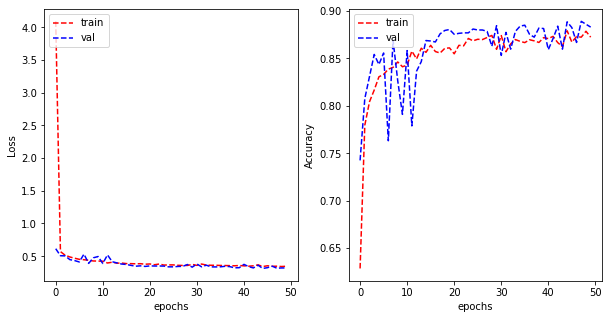

In [977]:
#2 complex
plot_curve(sixth)

In [978]:
mc = ModelCheckpoint('best_model_cc3.h5', monitor = 'val_accuracy', mode='max',
                    verbose=1, save_best_only=True)

final_ES = cnn_s.fit(cc_train_generator, validation_data = cc_validation_generator, epochs=200, verbose=0, 
                  callbacks=[es, mc])


Epoch 00001: val_accuracy improved from -inf to 0.88883, saving model to best_model_cc3.h5

Epoch 00002: val_accuracy did not improve from 0.88883
Epoch 00002: early stopping


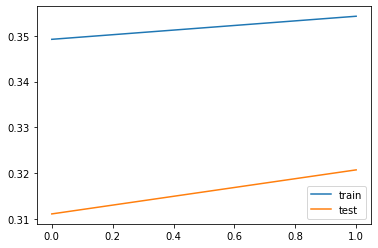

In [979]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [980]:
best_model_cc3 = load_model('best_model_cc3.h5')

In [981]:
mc = ModelCheckpoint('best_model_cc4.h5', monitor = 'val_accuracy', mode='max',
                    verbose=1, save_best_only=True)

final_ES = cnn_s.fit(cc_aug_train_generator, validation_data = cc_aug_validation_generator, epochs=200, verbose=0, 
                  callbacks=[es, mc])


Epoch 00001: val_accuracy improved from -inf to 0.88530, saving model to best_model_cc4.h5

Epoch 00002: val_accuracy improved from 0.88530 to 0.88782, saving model to best_model_cc4.h5

Epoch 00003: val_accuracy did not improve from 0.88782
Epoch 00003: early stopping


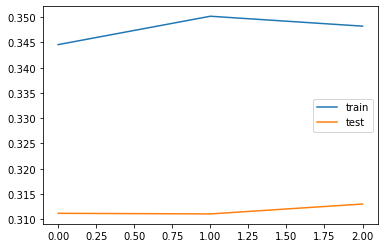

In [982]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [983]:
best_model_cc4 = load_model('best_model_cc4.h5')

### CellType Classifier

In [984]:
#Start with a few base line models to see if we can improve upon them

In [985]:
input_shape = (27, 27, 3)


cnn_s = Sequential()
cnn_s.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_s.add(MaxPooling2D(pool_size=(2,2)))
cnn_s.add(Dropout(0.2))
cnn_s.add(Flatten())
cnn_s.add(Dense(128, activation='relu'))
cnn_s.add(Dense(4, activation='softmax'))

cnn_s.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [986]:
single = cnn_s.fit(cl_train_generator, validation_data = cl_validation_generator, epochs=50, verbose=0)

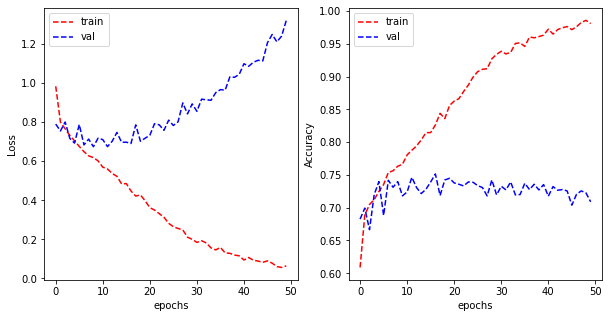

In [987]:
#32
plot_curve(single)

In [988]:
#adding a second layer before regularization to see if we can get any improvements
cnn_d = Sequential()
cnn_d.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_d.add(MaxPooling2D(pool_size=(2,2)))
cnn_d.add(Dropout(0.2))

cnn_d.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn_d.add(MaxPooling2D(pool_size=(2, 2)))
cnn_d.add(Dropout(0.2))

cnn_d.add(Flatten())
cnn_d.add(Dense(128, activation='relu'))
cnn_d.add(Dense(4, activation='softmax'))

cnn_d.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [989]:
double = cnn_d.fit(cl_train_generator, validation_data = cl_validation_generator, epochs=50, verbose=0)

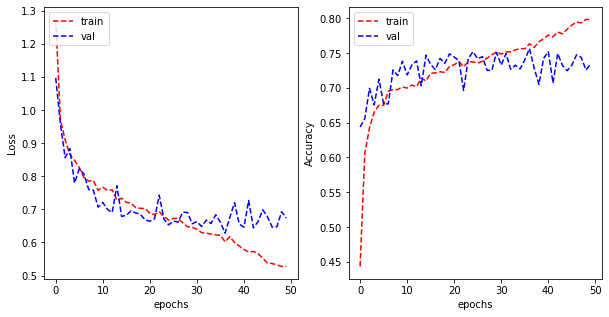

In [990]:
#8, 16
plot_curve(double)

In [991]:
#adding a third layer to check the output 
cnn_t = Sequential()
cnn_t.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
cnn_t.add(Dropout(0.2))

cnn_t.add(Flatten())
cnn_t.add(Dense(128, activation='relu'))
cnn_t.add(Dense(4, activation='softmax'))

cnn_t.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [992]:
triple = cnn_t.fit(cl_train_generator, validation_data = cl_validation_generator, epochs=50, verbose=0)

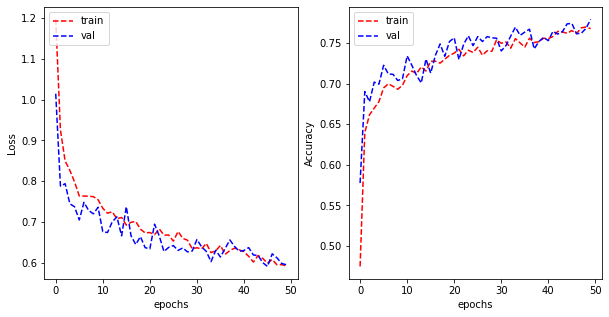

In [993]:
plot_curve(triple)

In [994]:
#The triple layer gives us the most consistant training and validation accuracy, that will be selected for further testing
#regularize via a ridge penalty
reg_lambda = 0.001

cnn_t = Sequential()
cnn_t.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(8, kernel_size=(3,3), activation='relu'))
cnn_t.add(Dropout(0.2))

cnn_t.add(Flatten())
cnn_t.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(reg_lambda)))
cnn_t.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(reg_lambda)))

cnn_t.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [995]:
reg_lambda = 0.001

cnn_t = Sequential()
cnn_t.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn_t.add(MaxPooling2D(pool_size=(2,2)))
cnn_t.add(Dropout(0.2))

cnn_t.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn_t.add(Dropout(0.2))

cnn_t.add(Flatten())
cnn_t.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(reg_lambda)))
cnn_t.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(reg_lambda)))

cnn_t.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [996]:
final = cnn_t.fit(cl_train_generator, validation_data = cl_validation_generator, epochs=50, verbose=0)

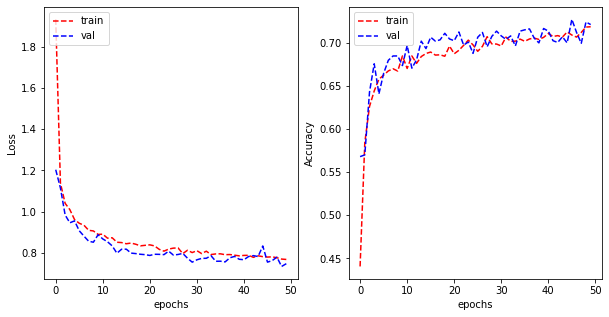

In [997]:
plot_curve(final)

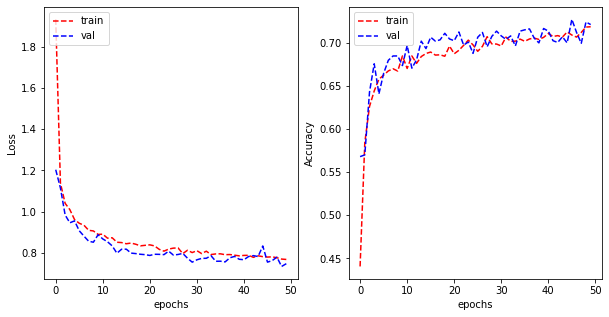

In [998]:
#0.001 l1
plot_curve(final)

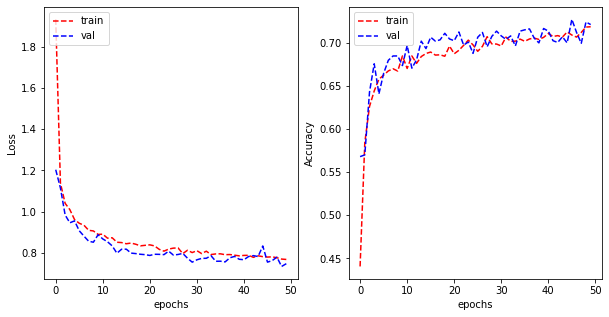

In [999]:
#0.001, l2 
plot_curve(final)

In [1000]:
#The model is still slightly underfitting, so we can try to regularize via image augmentation
#Since our images seem to 
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', horizontal_flip =True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', horizontal_flip =True, vertical_flip=True)

batch_size = 32

cl_aug_train_generator = train_datagen.flow_from_dataframe(
        dataframe=cl_train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cl_aug_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=cl_val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [1001]:
final = cnn_t.fit(cl_aug_train_generator, validation_data = cl_aug_validation_generator, epochs=50, verbose=0)

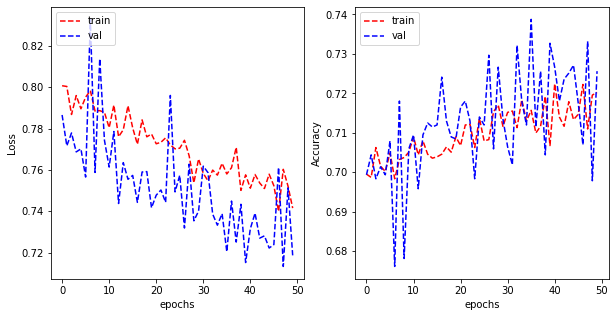

In [1002]:
#This augmentation improves accuracy but causes more overfitting 
plot_curve(final)

In [1003]:
#Try to modify the convultions with the two  that seem to be suggestive of useful predictions, without augmentation
reg_lambda = 0.001
complexity = 6
epochs = 50
tracker = []

for i in range(1, complexity):
    cnn_s = Sequential()
    cnn_s.add(Conv2D(32*i, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Conv2D(16*i, kernel_size=(3,3), activation='relu'))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Conv2D(8*i, kernel_size=(3,3), activation='relu'))
    cnn_s.add(MaxPooling2D(pool_size=(2,2)))
    cnn_s.add(Dropout(0.2))

    cnn_s.add(Flatten())
    cnn_s.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(reg_lambda)))
    cnn_s.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(reg_lambda)))

    cnn_s.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    
    log = cnn_s.fit(cl_train_generator, validation_data = cl_validation_generator, epochs=epochs, verbose=0)
    tracker.append((str(i), log))
    

(0.0, 49.0)

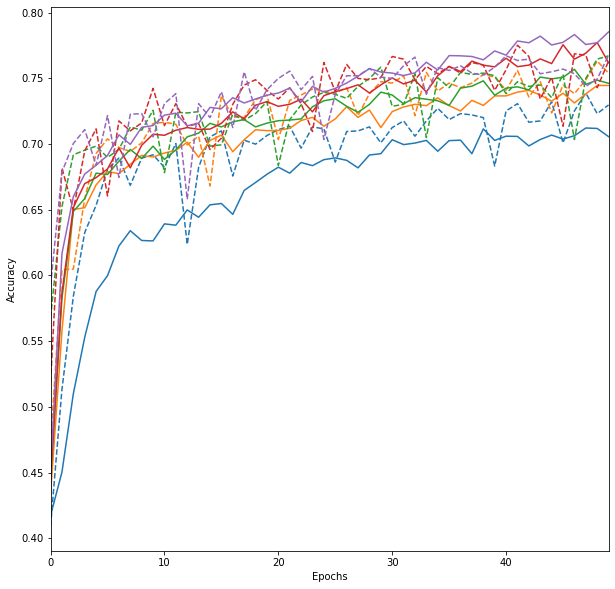

In [1004]:
plt.figure(figsize=(10,10))

for count, history in tracker:
    #print(history.history)
    i = int(count)
    cc = (8*i)+(16*i)+(32*i)
    val = plt.plot(history.epoch, history.history['val_'+ 'accuracy'], '--', label=count.title()+' Validation accuracy for '+str(cc)+" total convolutions")
    plt.plot(history.epoch, history.history['accuracy'], 
             color=val[0].get_color(), label= count.title()+' Accuracy for '+str(cc)+" total convolutions")
    

plt.xlabel('Epochs')
plt.ylabel('accuracy'.replace('_', ' ').title())
plt.xlim([0, max(history.epoch)])

The key refuses to show up, but the output can be read as this ...

blue: Accuracy for 56 total convultions 
blue dotted: Validation Accuracy for 112 total convultions 

orange: Accuracy for 112 total convultions 
O dotted:Validation Accuracy for 112 total convultions 

green: Accuracy for 168 total convultions 
G dotted:Validation Accuracy for 168 total convultions 

red: Accuracy for 224 total convultions 
r dotted: Validation Accuracy for  224 total convultions 

purple: Accuracy for  280 total convultions 
p dotted: Validation Accuracy for 280 total convultions 


In [1005]:
reg_lambda = 0.001
complex = 6

cnn_cl = Sequential()
cnn_cl.add(Conv2D(8*complex, kernel_size=(3,3), activation='relu', input_shape=input_shape))
cnn_cl.add(MaxPooling2D(pool_size=(2,2)))
cnn_cl.add(Dropout(0.2))

cnn_cl.add(Conv2D(16*complex, kernel_size=(3,3), activation='relu'))
cnn_cl.add(MaxPooling2D(pool_size=(2,2)))
cnn_cl.add(Dropout(0.2))

cnn_cl.add(Conv2D(32*complex, kernel_size=(3,3), activation='relu'))
cnn_cl.add(MaxPooling2D(pool_size=(2,2)))
cnn_cl.add(Dropout(0.2))

cnn_cl.add(Flatten())
cnn_cl.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
cnn_cl.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

cnn_cl.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [1006]:
final = cnn_cl.fit(cl_aug_train_generator, validation_data = cl_aug_validation_generator, epochs=50, verbose=0)

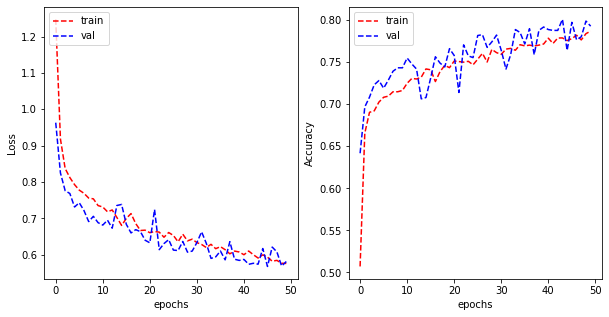

In [1007]:
#6
plot_curve(final)

This model was overfitting to the provided training set. This means that the model was trained too much on known data and in turn it was not performing well on the testing set. An accuracy of only 35% was achieved. 

I will be adding early stopping in an attempt to solve this issue.

In [1008]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1)
final_ES = cnn_cl.fit(cl_aug_train_generator, validation_data = cl_aug_validation_generator, epochs=50, verbose=0, 
                  callbacks=[es])

Epoch 00002: early stopping


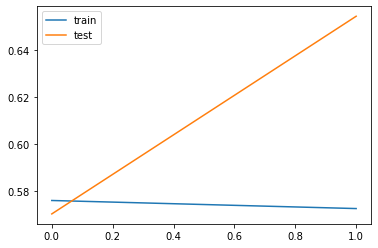

In [1009]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [1010]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 200)
final_ES = cnn_cl.fit(cl_aug_train_generator, validation_data = cl_aug_validation_generator, epochs=50, verbose=0, 
                  callbacks=[es])

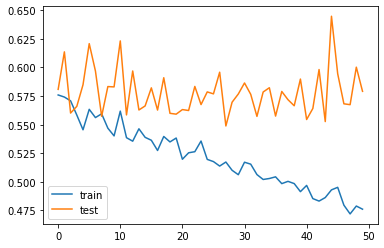

In [1011]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [1012]:
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode='max',
                    verbose=1, save_best_only=True)


In [1013]:
final_ES = cnn_cl.fit(cl_aug_train_generator, validation_data = cl_aug_validation_generator, epochs=200, verbose=0, 
                  callbacks=[es, mc])


Epoch 00001: val_accuracy improved from -inf to 0.77767, saving model to best_model.h5

Epoch 00002: val_accuracy improved from 0.77767 to 0.78979, saving model to best_model.h5

Epoch 00003: val_accuracy improved from 0.78979 to 0.79282, saving model to best_model.h5

Epoch 00004: val_accuracy did not improve from 0.79282

Epoch 00005: val_accuracy did not improve from 0.79282

Epoch 00006: val_accuracy improved from 0.79282 to 0.79838, saving model to best_model.h5

Epoch 00007: val_accuracy improved from 0.79838 to 0.79990, saving model to best_model.h5

Epoch 00008: val_accuracy did not improve from 0.79990

Epoch 00009: val_accuracy did not improve from 0.79990

Epoch 00010: val_accuracy did not improve from 0.79990

Epoch 00011: val_accuracy did not improve from 0.79990

Epoch 00012: val_accuracy improved from 0.79990 to 0.80243, saving model to best_model.h5

Epoch 00013: val_accuracy did not improve from 0.80243

Epoch 00014: val_accuracy did not improve from 0.80243

Epoch 00


Epoch 00142: val_accuracy did not improve from 0.80849

Epoch 00143: val_accuracy did not improve from 0.80849

Epoch 00144: val_accuracy did not improve from 0.80849

Epoch 00145: val_accuracy did not improve from 0.80849

Epoch 00146: val_accuracy did not improve from 0.80849

Epoch 00147: val_accuracy did not improve from 0.80849

Epoch 00148: val_accuracy did not improve from 0.80849

Epoch 00149: val_accuracy did not improve from 0.80849

Epoch 00150: val_accuracy did not improve from 0.80849

Epoch 00151: val_accuracy did not improve from 0.80849

Epoch 00152: val_accuracy did not improve from 0.80849

Epoch 00153: val_accuracy did not improve from 0.80849

Epoch 00154: val_accuracy did not improve from 0.80849

Epoch 00155: val_accuracy did not improve from 0.80849

Epoch 00156: val_accuracy did not improve from 0.80849

Epoch 00157: val_accuracy did not improve from 0.80849

Epoch 00158: val_accuracy did not improve from 0.80849

Epoch 00159: val_accuracy did not improve from 

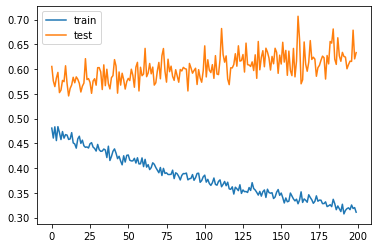

In [1014]:
plt.plot(final_ES.history['loss'], label='train')
plt.plot(final_ES.history['val_loss'], label='test')
plt.legend()
plt.show()

In [1015]:
best_model_cl = load_model('best_model.h5')

# Model Evaluation


## Fitting the models

In [1016]:
svm_cancer.fit(train_cancer_X, cancer_flat_train_y)

SVC(C=1, gamma=0.001)

In [1017]:
knn_cancer.fit(train_cancer_X, cancer_flat_train_y)

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=11,
                     weights='distance')

In [1018]:
rfc_cancer.fit(train_cancer_X, cancer_flat_train_y)

RandomForestClassifier(n_estimators=1000)

In [1019]:
svm_cell.fit(train_cell_X, cell_flat_train_y)

SVC(C=1, gamma=0.001)

In [1020]:
cell_knn.fit(train_cell_X, cell_flat_train_y)

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                     weights='distance')

In [1021]:
rfc_cell.fit(train_cell_X, cell_flat_train_y)

RandomForestClassifier(n_estimators=2000)

## Testing the model against the holdout dataset

In [1027]:
from sklearn.metrics import (accuracy_score, classification_report)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [1034]:
plot_labels = ['SVM','K Nearest Neighbors', 'Random forest', 'CNN']
#Cancer data set
pred_cancer = []

#SVM
y = svm_cancer.predict(test_cancer_X)
x = round(accuracy_score(cancer_flat_test_y, y), 3)*100
z = round(mean_squared_error(cancer_flat_test_y, y), 3)
f1 = round(f1_score(cancer_flat_test_y, y, average='weighted'),3)
rec = round(recall_score(cancer_flat_test_y, y, average='weighted'),3)
prec = round(precision_score(cancer_flat_test_y, y, average='weighted', labels=np.unique(y)),3)
print("SVM: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec) +"\n")
pred_cancer.append(x)

#KNN
y = knn_cancer.predict(test_cancer_X)
x = round(accuracy_score(cancer_flat_test_y, y), 3)*100
z = round(mean_squared_error(cancer_flat_test_y, y), 3)
f1 = round(f1_score(cancer_flat_test_y, y, average='weighted'),3)
rec = round(recall_score(cancer_flat_test_y, y, average='weighted'),3)
prec = round(precision_score(cancer_flat_test_y, y, average='weighted', labels=np.unique(y)),3)

print("KNN: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec) +"\n")
pred_cancer.append(x)


#RF
y = rfc_cancer.predict(test_cancer_X)
x = round(accuracy_score(cancer_flat_test_y, y), 3)*100
z = round(mean_squared_error(cancer_flat_test_y, y), 3)
f1 = round(f1_score(cancer_flat_test_y, y, average='weighted'),3)
rec = round(recall_score(cancer_flat_test_y, y, average='weighted'),3)
prec = round(precision_score(cancer_flat_test_y, y, average='weighted', labels=np.unique(y)),3)

print("RFC: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec) +"\n")
pred_cancer.append(x)

#CNN
y = best_model_cc2.predict(cc_test_generator)
cc_pred = []
for i in y:
    cc_pred.append(np.argmax(i))

x = round(accuracy_score(cancer_flat_test_y, cc_pred), 3)*100
z = round(mean_squared_error(cancer_flat_test_y, cc_pred), 3)
f1 = round(f1_score(cancer_flat_test_y, cc_pred, average='weighted'),3)
rec = round(recall_score(cancer_flat_test_y, cc_pred, average='weighted'),3)
prec = round(precision_score(cancer_flat_test_y, cc_pred, average='weighted', labels=np.unique(cc_pred)),3)

print("CNN: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec))
pred_cancer.append(x)


SVM: 
Error rate: 0.399
Accuracy rate: 60.099999999999994
F1 score: 0.451
Recall: 0.601
Precision score: 0.601

KNN: 
Error rate: 0.33
Accuracy rate: 67.0
F1 score: 0.624
Recall: 0.67
Precision score: 0.686

RFC: 
Error rate: 0.218
Accuracy rate: 78.2
F1 score: 0.78
Recall: 0.782
Precision score: 0.78

CNN: 
Error rate: 0.475
Accuracy rate: 52.5
F1 score: 0.524
Recall: 0.525
Precision score: 0.523


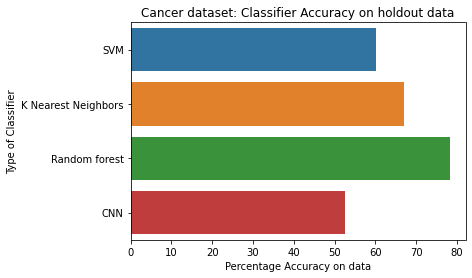

In [1035]:
ax = sns.barplot(x=pred_cancer, y=plot_labels)
plt.title("Cancer dataset: Classifier Accuracy on holdout data")
ax.set(xlabel='Percentage Accuracy on data', ylabel='Type of Classifier')
plt.show()

In [1037]:
#cell dataset
pred_cells = []

#SVM
y = svm_cell.predict(test_cell_X)
x = round(accuracy_score(cell_flat_test_y, y), 3)
z = round(mean_squared_error(cell_flat_test_y, y), 3)
f1 = round(f1_score(cell_flat_test_y, y, average='weighted'),3)
rec = round(recall_score(cell_flat_test_y, y, average='weighted'),3)
prec = round(precision_score(cell_flat_test_y, y, average='weighted', labels=np.unique(y)),3)

print("SVM: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec) +"\n")
pred_cells.append(x)

#KNN
y = cell_knn.predict(test_cell_X)
x = round(accuracy_score(cell_flat_test_y, y), 3)
z = round(mean_squared_error(cell_flat_test_y, y), 3)
f1 = round(f1_score(cell_flat_test_y, y, average='weighted'),3)
rec = round(recall_score(cell_flat_test_y, y, average='weighted'),3)
prec = round(precision_score(cell_flat_test_y, y, average='weighted', labels=np.unique(y)),3)

print("KNN: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec) +"\n")
pred_cells.append(x)

#RF
y = rfc_cell.predict(test_cell_X)
x = round(accuracy_score(cell_flat_test_y, y), 3)
z = round(mean_squared_error(cell_flat_test_y, y), 3)
f1 = round(f1_score(cell_flat_test_y, y, average='weighted'),3)
rec = round(recall_score(cell_flat_test_y, y, average='weighted'),3)
prec = round(precision_score(cell_flat_test_y, y, average='weighted', labels=np.unique(y)),3)

print("RFC: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec) +"\n")
pred_cells.append(x)

#CNN
y = best_model_cl.predict(cl_test_generator)
cnn_pred = []
for i in y:
    cnn_pred.append(np.argmax(i))

x = round(accuracy_score(cell_flat_test_y, cnn_pred), 3)
z = round(mean_squared_error(cell_flat_test_y, cnn_pred), 3)
f1 = round(f1_score(cell_flat_test_y, cnn_pred, average='weighted'),3)
rec = round(recall_score(cell_flat_test_y, cnn_pred, average='weighted'),3)
prec = round(precision_score(cell_flat_test_y, cnn_pred, average='weighted', labels=np.unique(cnn_pred)),3)

print("CNN: ")
print("Error rate: " + str(z))
print("Accuracy rate: " + str(x))
print("F1 score: " + str(f1))
print("Recall: " + str(rec))
print("Precision score: " + str(prec) +"\n")
pred_cells.append(x)

SVM: 
Error rate: 1.193
Accuracy rate: 0.399
F1 score: 0.228
Recall: 0.399
Precision score: 0.399

KNN: 
Error rate: 2.16
Accuracy rate: 0.433
F1 score: 0.422
Recall: 0.433
Precision score: 0.507

RFC: 
Error rate: 1.074
Accuracy rate: 0.615
F1 score: 0.549
Recall: 0.615
Precision score: 0.668

CNN: 
Error rate: 1.816
Accuracy rate: 0.281
F1 score: 0.275
Recall: 0.281
Precision score: 0.274



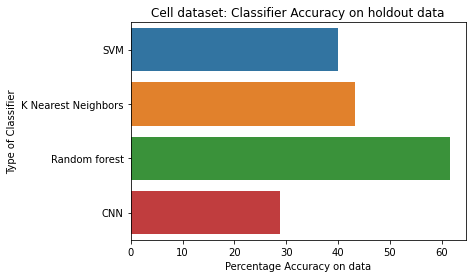

In [1026]:
ax = sns.barplot(x=pred_cells, y=plot_labels)
plt.title("Cell dataset: Classifier Accuracy on holdout data")
ax.set(xlabel='Percentage Accuracy on data', ylabel='Type of Classifier')
plt.show()

In both models, the random forest seems to have dealt with the unseen data better.

The CNN suprisingly did not achieve very high scores in either datasets, coming last in the rankings.

This means that the CNN models were overfit to the training and validation data, and could not properly predict unseen data. This may be due to incorrect structure and incorrectly tuned hyperparameters.

Receiving only a 30.7% accuracy on the cell data and 53% accuracy on the cancer data means that in it's current form, the CNN is not recommended as the model to be used in a real world situation.

The random forest, receiving a 62% on the cell data and 78.2% accuracy on the cancer data, cannot be recommened in its current form either.

The random forest classifier is robust to outliers, able to be scaled and can naturally model non-linear decision boundaries.

However, in terms of adaptability and growth, the CNN model can be further improved via larger datasets, regularization and hyper parameter tuning. This means that it is suggested to improve the CNN model rather than settle for a random forest. 